In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [248]:
def clean_pink_sheet_monthly(xls_path, sheet_name="Monthly Prices"):
    raw = pd.read_excel(xls_path, sheet_name=sheet_name, header=None)

    date_pat = re.compile(r"^\d{4}M(0[1-9]|1[0-2])$")
    first_data_idx = next(i for i,v in enumerate(raw.iloc[:,0].astype(str)) if date_pat.match(v))

    name_row = raw.iloc[first_data_idx-2].astype(str).replace("nan","")
    unit_row = raw.iloc[first_data_idx-1].astype(str).replace("nan","")

    cols = []
    for n,u in zip(name_row, unit_row):
        n,u = n.strip(), u.strip()
        if n and u: cols.append(f"{n} [{u}]")
        elif n:     cols.append(n)
        elif u:     cols.append(u)
        else:       cols.append("")
    cols[0] = "Date"

    df = raw.iloc[first_data_idx:].copy()
    df.columns = cols
    df = df.dropna(axis=1, how="all")
    df = df.loc[:, ~df.columns.duplicated()]

    df["Date"] = (df["Date"].astype(str).str.replace("M","-", regex=False)
                  .pipe(pd.to_datetime, format="%Y-%m", errors="coerce"))
    df = df[df["Date"].notna()].reset_index(drop=True)

    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

monthly = clean_pink_sheet_monthly("Commodity-Price-Analysis-16.04.2025-1 (2).xlsm")
monthly.to_csv("monthly_prices_clean.csv", index=False)


In [249]:
monthly

Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0   1960-01-01                      1.630000                       1.630   
1   1960-02-01                      1.630000                       1.630   
2   1960-03-01                      1.630000                       1.630   
3   1960-04-01                      1.630000                       1.630   
4   1960-05-01                      1.630000                       1.630   
..         ...                           ...                         ...   
778 2024-11-01                     72.291667                      74.395   
779 2024-12-01                     72.311000                      73.833   
780 2025-01-01                     78.162000                      79.206   
781 2025-02-01                     73.819000                      75.157   
782 2025-03-01                     70.701333                      72.574   

     Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                          1.63                       NaN   
1                          1.63                       NaN   
2                          1.63                       NaN   
3                          1.63                       NaN   
4                          1.63                       NaN   
..                          ...                       ...   
778                       72.79                     69.69   
779                       73.31                     69.79   
780                       80.14                     75.14   
781                       74.97                     71.33   
782                       71.71                     67.82   

     Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                          NaN                              NaN   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                          NaN                              NaN   
..                         ...                              ...   
778                     142.12                           106.82   
779                     129.81                           105.47   
780                     118.60                           103.28   
781                     106.93                           100.41   
782                     103.97                            97.99   

     Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
0                         0.1400                         0.404774   
1                         0.1400                         0.404774   
2                         0.1400                         0.404774   
3                         0.1400                         0.404774   
4                         0.1400                         0.404774   
..                           ...                              ...   
778                       2.1045                        13.926400   
779                       3.0229                        13.856621   
780                       4.0991                        14.663512   
781                       4.2226                        15.340532   
782                       4.1281                        13.235407   

     Liquefied natural gas, Japan [($/mmbtu)]  ...  Aluminum [($/mt)]  \
0                                         NaN  ...         511.471832   
1                                         NaN  ...         511.471832   
2                                         NaN  ...         511.471832   
3                                         NaN  ...         511.471832   
4                                         NaN  ...         511.471832   
..                                        ...  ...                ...   
778                                 12.822731  ...        2582.190000   
779                                 12.640616  ...        2541.020000   
780                                 13.193106  ...        2573.400000   


In [250]:
monthly.isna().mean().sort_values(ascending=False).head(20)


Rice, Viet Namese 5% [($/mt)]               0.687101
Sunflower oil [($/mt)]                      0.651341
Rapeseed oil [($/mt)]                       0.644955
Rubber, TSR20 ** [($/kg)]                   0.597701
Banana, Europe [($/kg)]                     0.567050
Palm kernel oil [($/mt)]                    0.551724
Sawnwood, Cameroon [($/cubic meter)]        0.475096
Rice, Thai 25% [($/mt)]                     0.408685
Rice, Thai A.1 [($/mt)]                     0.398467
Coal, South African ** [($/mt)]             0.367816
Crude oil, WTI [($/bbl)]                    0.337165
Groundnuts [($/mt)]                         0.306513
Wheat, US SRW [($/mt)]                      0.300128
Plywood [(cents/sheet)]                     0.291188
Fish meal [($/mt)]                          0.291188
Natural gas index [(2010=100)]              0.260536
Liquefied natural gas, Japan [($/mmbtu)]    0.260536
Lamb ** [($/kg)]                            0.168582
Coal, Australian [($/mt)]                   0.

In [251]:
df = monthly.copy()

thresh = 0.7
to_drop = df.columns[df.isna().mean() > thresh]
df = df.drop(columns=to_drop)

print("These columns were removed:")
print(list(to_drop))

for col in df.columns[1:]:
    if df[col].isna().any():
        df[col] = df[col].interpolate(method="linear")
        df[col] = df[col].fillna(method="ffill").fillna(method="bfill")

df.to_csv("monthly_prices_final.csv", index=False)


These columns were removed:
[]


C:\Users\NV_USER\AppData\Local\Temp\ipykernel_20192\3362393528.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method="ffill").fillna(method="bfill")


In [252]:
df1=pd.read_csv("monthly_prices_final.csv")
df1

Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0    1960-01-01                      1.630000                       1.630   
1    1960-02-01                      1.630000                       1.630   
2    1960-03-01                      1.630000                       1.630   
3    1960-04-01                      1.630000                       1.630   
4    1960-05-01                      1.630000                       1.630   
..          ...                           ...                         ...   
778  2024-11-01                     72.291667                      74.395   
779  2024-12-01                     72.311000                      73.833   
780  2025-01-01                     78.162000                      79.206   
781  2025-02-01                     73.819000                      75.157   
782  2025-03-01                     70.701333                      72.574   

     Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                          1.63                     35.30   
1                          1.63                     35.30   
2                          1.63                     35.30   
3                          1.63                     35.30   
4                          1.63                     35.30   
..                          ...                       ...   
778                       72.79                     69.69   
779                       73.31                     69.79   
780                       80.14                     75.14   
781                       74.97                     71.33   
782                       71.71                     67.82   

     Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                         7.80                            29.34   
1                         7.80                            29.34   
2                         7.80                            29.34   
3                         7.80                            29.34   
4                         7.80                            29.34   
..                         ...                              ...   
778                     142.12                           106.82   
779                     129.81                           105.47   
780                     118.60                           103.28   
781                     106.93                           100.41   
782                     103.97                            97.99   

     Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
0                         0.1400                         0.404774   
1                         0.1400                         0.404774   
2                         0.1400                         0.404774   
3                         0.1400                         0.404774   
4                         0.1400                         0.404774   
..                           ...                              ...   
778                       2.1045                        13.926400   
779                       3.0229                        13.856621   
780                       4.0991                        14.663512   
781                       4.2226                        15.340532   
782                       4.1281                        13.235407   

     Liquefied natural gas, Japan [($/mmbtu)]  ...  Aluminum [($/mt)]  \
0                                    2.771163  ...         511.471832   
1                                    2.771163  ...         511.471832   
2                                    2.771163  ...         511.471832   
3                                    2.771163  ...         511.471832   
4                                    2.771163  ...         511.471832   
..                                        ...  ...                ...   
778                                 12.822731  ...        2582.190000   
779                                 12.640616  ...        2541.020000   
780                                 13.193106  ...        2573

In [253]:
df1.isna().sum().sum()

0

In [254]:
df = pd.read_excel("Inflation-data.xlsx", sheet_name="hcpi_m")

print(df.columns.tolist())

['Country Code', 'IMF Country Code', 'Country', 'Indicator Type', 'Series Name', 197001, 197002, 197003, 197004, 197005, 197006, 197007, 197008, 197009, 197010, 197011, 197012, 197101, 197102, 197103, 197104, 197105, 197106, 197107, 197108, 197109, 197110, 197111, 197112, 197201, 197202, 197203, 197204, 197205, 197206, 197207, 197208, 197209, 197210, 197211, 197212, 197301, 197302, 197303, 197304, 197305, 197306, 197307, 197308, 197309, 197310, 197311, 197312, 197401, 197402, 197403, 197404, 197405, 197406, 197407, 197408, 197409, 197410, 197411, 197412, 197501, 197502, 197503, 197504, 197505, 197506, 197507, 197508, 197509, 197510, 197511, 197512, 197601, 197602, 197603, 197604, 197605, 197606, 197607, 197608, 197609, 197610, 197611, 197612, 197701, 197702, 197703, 197704, 197705, 197706, 197707, 197708, 197709, 197710, 197711, 197712, 197801, 197802, 197803, 197804, 197805, 197806, 197807, 197808, 197809, 197810, 197811, 197812, 197901, 197902, 197903, 197904, 197905, 197906, 197907,

In [255]:
id_vars = ["Country Code", "IMF Country Code", "Country", "Indicator Type", "Series Name"]

value_vars = [col for col in df.columns if isinstance(col, int)]

df_long = df.melt(id_vars=id_vars, value_vars=value_vars,
                  var_name="Date", value_name="Value")

df_long["Date"] = pd.to_datetime(df_long["Date"].astype(str), format="%Y%m")

df_long

Country Code  IMF Country Code  \
0                                                     ABW             314.0   
1                                                     AFG             512.0   
2                                                     AGO             614.0   
3                                                     ALB             914.0   
4                                                     ARE             466.0   
...                                                   ...               ...   
123313                                                YEM             474.0   
123314                                                ZAF             199.0   
123315                                                ZMB             754.0   
123316                                                ZWE             698.0   
123317  Note: "IFS" indicates IMF's International Fina...               NaN   

                     Country Indicator Type                    Series Name  \
0                      Aruba          Index  Headline Consumer Price Index   
1                Afghanistan          Index  Headline Consumer Price Index   
2                     Angola          Index  Headline Consumer Price Index   
3                    Albania          Index  Headline Consumer Price Index   
4       United Arab Emirates          Index  Headline Consumer Price Index   
...                      ...            ...                            ...   
123313           Yemen, Rep.          Index  Headline Consumer Price Index   
123314          South Africa          Index  Headline Consumer Price Index   
123315                Zambia          Index  Headline Consumer Price Index   
123316              Zimbabwe          Index  Headline Consumer Price Index   
123317                   NaN            NaN                            NaN   

             Date  Value  
0      1970-01-01    NaN  
1      1970-01-01    NaN  
2      1970-01-01    NaN  
3      1970-01-01    NaN  
4      1970-01-01    NaN  
...           ...    ...  
123313 2025-03-01    NaN  
123314 2025-03-01    NaN  
123315 2025-03-01    NaN  
123316 2025-03-01    NaN  
123317 2025-03-01    NaN  

[123318 rows x 7 columns]

In [256]:
inflation = df_long[["Date", "Value"]]

inflation["Date"] = pd.to_datetime(inflation["Date"])

global_inflation = inflation.groupby("Date")["Value"].mean().reset_index()
global_inflation.rename(columns={"Value": "Global_Inflation"}, inplace=True)

df = pd.read_csv("monthly_prices_final.csv", parse_dates=["Date"])

df = df.merge(global_inflation, on="Date", how="left")

print(df.head())

df.to_csv("monthly_prices_with_inflation.csv", index=False)

        Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0 1960-01-01                          1.63                        1.63   
1 1960-02-01                          1.63                        1.63   
2 1960-03-01                          1.63                        1.63   
3 1960-04-01                          1.63                        1.63   
4 1960-05-01                          1.63                        1.63   

   Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                        1.63                      35.3   
1                        1.63                      35.3   
2                        1.63                      35.3   
3                        1.63                      35.3   
4                        1.63                      35.3   

   Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                        7.8                            29.34   
1                        7.8                            29.34   
2    

C:\Users\NV_USER\AppData\Local\Temp\ipykernel_20192\3398410483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation["Date"] = pd.to_datetime(inflation["Date"])


In [257]:
df11=pd.read_csv("monthly_prices_with_inflation.csv")
df11

Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0    1960-01-01                      1.630000                       1.630   
1    1960-02-01                      1.630000                       1.630   
2    1960-03-01                      1.630000                       1.630   
3    1960-04-01                      1.630000                       1.630   
4    1960-05-01                      1.630000                       1.630   
..          ...                           ...                         ...   
778  2024-11-01                     72.291667                      74.395   
779  2024-12-01                     72.311000                      73.833   
780  2025-01-01                     78.162000                      79.206   
781  2025-02-01                     73.819000                      75.157   
782  2025-03-01                     70.701333                      72.574   

     Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                          1.63                     35.30   
1                          1.63                     35.30   
2                          1.63                     35.30   
3                          1.63                     35.30   
4                          1.63                     35.30   
..                          ...                       ...   
778                       72.79                     69.69   
779                       73.31                     69.79   
780                       80.14                     75.14   
781                       74.97                     71.33   
782                       71.71                     67.82   

     Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                         7.80                            29.34   
1                         7.80                            29.34   
2                         7.80                            29.34   
3                         7.80                            29.34   
4                         7.80                            29.34   
..                         ...                              ...   
778                     142.12                           106.82   
779                     129.81                           105.47   
780                     118.60                           103.28   
781                     106.93                           100.41   
782                     103.97                            97.99   

     Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
0                         0.1400                         0.404774   
1                         0.1400                         0.404774   
2                         0.1400                         0.404774   
3                         0.1400                         0.404774   
4                         0.1400                         0.404774   
..                           ...                              ...   
778                       2.1045                        13.926400   
779                       3.0229                        13.856621   
780                       4.0991                        14.663512   
781                       4.2226                        15.340532   
782                       4.1281                        13.235407   

     Liquefied natural gas, Japan [($/mmbtu)]  ...  \
0                                    2.771163  ...   
1                                    2.771163  ...   
2                                    2.771163  ...   
3                                    2.771163  ...   
4                                    2.771163  ...   
..                                        ...  ...   
778                                 12.822731  ...   
779                                 12.640616  ...   
780                                 13.193106  ...   
781                                 12.781781  ...   
782                                 12.700000  ...   

     Iron ore, cfr spot [($/dmtu)]  Copper [($/mt)]  Lead [($/mt)]  \


In [258]:

events = [
    ("Gulf_War", "1990-08-01", "1991-03-31"),
    ("Asia_Financial_Crisis", "1997-07-01", "1998-12-31"),
    ("Kosovo_War", "1998-02-01", "1999-06-30"),
    ("9_11_Attacks", "2001-09-01", "2001-12-31"),
    ("Afghanistan_War", "2001-10-01", "2021-08-31"),
    ("Iraq_War", "2003-03-01", "2011-12-31"),
    ("Global_Financial_Crisis", "2008-09-01", "2009-06-30"),
    ("Arab_Spring", "2011-01-01", "2012-12-31"),
    ("Ukraine_Crimea", "2014-02-01", "2014-12-31"),
    ("COVID19", "2020-03-01", "2021-12-31"),
    ("Russia_Ukraine_War", "2022-02-01", None),
    ("Gaza_War", "2023-10-01", None)
]

wars = pd.DataFrame(events, columns=["Event", "Start", "End"])
wars["Start"] = pd.to_datetime(wars["Start"])
wars["End"] = pd.to_datetime(wars["End"])

df["War_Indicator"] = 0
df["War_Name"] = None

for _, row in wars.iterrows():
    start, end = row["Start"], row["End"]
    if pd.isna(end):
        df.loc[df["Date"] >= start, ["War_Indicator", "War_Name"]] = [1, row["Event"]]
    else:
        df.loc[(df["Date"] >= start) & (df["Date"] <= end), ["War_Indicator", "War_Name"]] = [1, row["Event"]]

print(df[["Date", "War_Indicator", "War_Name"]].head(50))
df.to_csv("monthly_prices_with_inflation_with_war.csv", index=False)


         Date  War_Indicator War_Name
0  1960-01-01              0     None
1  1960-02-01              0     None
2  1960-03-01              0     None
3  1960-04-01              0     None
4  1960-05-01              0     None
5  1960-06-01              0     None
6  1960-07-01              0     None
7  1960-08-01              0     None
8  1960-09-01              0     None
9  1960-10-01              0     None
10 1960-11-01              0     None
11 1960-12-01              0     None
12 1961-01-01              0     None
13 1961-02-01              0     None
14 1961-03-01              0     None
15 1961-04-01              0     None
16 1961-05-01              0     None
17 1961-06-01              0     None
18 1961-07-01              0     None
19 1961-08-01              0     None
20 1961-09-01              0     None
21 1961-10-01              0     None
22 1961-11-01              0     None
23 1961-12-01              0     None
24 1962-01-01              0     None
25 1962-02-0

In [259]:
df

Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0   1960-01-01                      1.630000                       1.630   
1   1960-02-01                      1.630000                       1.630   
2   1960-03-01                      1.630000                       1.630   
3   1960-04-01                      1.630000                       1.630   
4   1960-05-01                      1.630000                       1.630   
..         ...                           ...                         ...   
778 2024-11-01                     72.291667                      74.395   
779 2024-12-01                     72.311000                      73.833   
780 2025-01-01                     78.162000                      79.206   
781 2025-02-01                     73.819000                      75.157   
782 2025-03-01                     70.701333                      72.574   

     Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                          1.63                     35.30   
1                          1.63                     35.30   
2                          1.63                     35.30   
3                          1.63                     35.30   
4                          1.63                     35.30   
..                          ...                       ...   
778                       72.79                     69.69   
779                       73.31                     69.79   
780                       80.14                     75.14   
781                       74.97                     71.33   
782                       71.71                     67.82   

     Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                         7.80                            29.34   
1                         7.80                            29.34   
2                         7.80                            29.34   
3                         7.80                            29.34   
4                         7.80                            29.34   
..                         ...                              ...   
778                     142.12                           106.82   
779                     129.81                           105.47   
780                     118.60                           103.28   
781                     106.93                           100.41   
782                     103.97                            97.99   

     Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
0                         0.1400                         0.404774   
1                         0.1400                         0.404774   
2                         0.1400                         0.404774   
3                         0.1400                         0.404774   
4                         0.1400                         0.404774   
..                           ...                              ...   
778                       2.1045                        13.926400   
779                       3.0229                        13.856621   
780                       4.0991                        14.663512   
781                       4.2226                        15.340532   
782                       4.1281                        13.235407   

     Liquefied natural gas, Japan [($/mmbtu)]  ...  Lead [($/mt)]  \
0                                    2.771163  ...         206.10   
1                                    2.771163  ...         203.70   
2                                    2.771163  ...         210.30   
3                                    2.771163  ...         213.60   
4                                    2.771163  ...         213.40   
..                                        ...  ...            ...   
778                                 12.822731  ...        1987.53   
779                                 12.640616  ...        1990.43   
780                                 13.193106  ...        1921.36   
781                                 12.7

In [260]:
df['War_Name'].isnull().sum().sum()

469

In [261]:
df['War_Name'].unique()

array([None, 'Gulf_War', 'Asia_Financial_Crisis', 'Kosovo_War',
       '9_11_Attacks', 'Afghanistan_War', 'Iraq_War',
       'Global_Financial_Crisis', 'Arab_Spring', 'Ukraine_Crimea',
       'COVID19', 'Russia_Ukraine_War', 'Gaza_War'], dtype=object)

In [262]:
df["War_Name"] = df["War_Name"].fillna("No_War")


In [263]:
df

Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0   1960-01-01                      1.630000                       1.630   
1   1960-02-01                      1.630000                       1.630   
2   1960-03-01                      1.630000                       1.630   
3   1960-04-01                      1.630000                       1.630   
4   1960-05-01                      1.630000                       1.630   
..         ...                           ...                         ...   
778 2024-11-01                     72.291667                      74.395   
779 2024-12-01                     72.311000                      73.833   
780 2025-01-01                     78.162000                      79.206   
781 2025-02-01                     73.819000                      75.157   
782 2025-03-01                     70.701333                      72.574   

     Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                          1.63                     35.30   
1                          1.63                     35.30   
2                          1.63                     35.30   
3                          1.63                     35.30   
4                          1.63                     35.30   
..                          ...                       ...   
778                       72.79                     69.69   
779                       73.31                     69.79   
780                       80.14                     75.14   
781                       74.97                     71.33   
782                       71.71                     67.82   

     Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                         7.80                            29.34   
1                         7.80                            29.34   
2                         7.80                            29.34   
3                         7.80                            29.34   
4                         7.80                            29.34   
..                         ...                              ...   
778                     142.12                           106.82   
779                     129.81                           105.47   
780                     118.60                           103.28   
781                     106.93                           100.41   
782                     103.97                            97.99   

     Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
0                         0.1400                         0.404774   
1                         0.1400                         0.404774   
2                         0.1400                         0.404774   
3                         0.1400                         0.404774   
4                         0.1400                         0.404774   
..                           ...                              ...   
778                       2.1045                        13.926400   
779                       3.0229                        13.856621   
780                       4.0991                        14.663512   
781                       4.2226                        15.340532   
782                       4.1281                        13.235407   

     Liquefied natural gas, Japan [($/mmbtu)]  ...  Lead [($/mt)]  \
0                                    2.771163  ...         206.10   
1                                    2.771163  ...         203.70   
2                                    2.771163  ...         210.30   
3                                    2.771163  ...         213.60   
4                                    2.771163  ...         213.40   
..                                        ...  ...            ...   
778                                 12.822731  ...        1987.53   
779                                 12.640616  ...        1990.43   
780                                 13.193106  ...        1921.36   
781                                 12.7

In [264]:
df.isnull().sum().sum()

120

In [265]:
df['Global_Inflation'].isnull().sum()

120

In [266]:
df["Global_Inflation"] = df["Global_Inflation"].ffill().bfill()
df

Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0   1960-01-01                      1.630000                       1.630   
1   1960-02-01                      1.630000                       1.630   
2   1960-03-01                      1.630000                       1.630   
3   1960-04-01                      1.630000                       1.630   
4   1960-05-01                      1.630000                       1.630   
..         ...                           ...                         ...   
778 2024-11-01                     72.291667                      74.395   
779 2024-12-01                     72.311000                      73.833   
780 2025-01-01                     78.162000                      79.206   
781 2025-02-01                     73.819000                      75.157   
782 2025-03-01                     70.701333                      72.574   

     Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                          1.63                     35.30   
1                          1.63                     35.30   
2                          1.63                     35.30   
3                          1.63                     35.30   
4                          1.63                     35.30   
..                          ...                       ...   
778                       72.79                     69.69   
779                       73.31                     69.79   
780                       80.14                     75.14   
781                       74.97                     71.33   
782                       71.71                     67.82   

     Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                         7.80                            29.34   
1                         7.80                            29.34   
2                         7.80                            29.34   
3                         7.80                            29.34   
4                         7.80                            29.34   
..                         ...                              ...   
778                     142.12                           106.82   
779                     129.81                           105.47   
780                     118.60                           103.28   
781                     106.93                           100.41   
782                     103.97                            97.99   

     Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
0                         0.1400                         0.404774   
1                         0.1400                         0.404774   
2                         0.1400                         0.404774   
3                         0.1400                         0.404774   
4                         0.1400                         0.404774   
..                           ...                              ...   
778                       2.1045                        13.926400   
779                       3.0229                        13.856621   
780                       4.0991                        14.663512   
781                       4.2226                        15.340532   
782                       4.1281                        13.235407   

     Liquefied natural gas, Japan [($/mmbtu)]  ...  Lead [($/mt)]  \
0                                    2.771163  ...         206.10   
1                                    2.771163  ...         203.70   
2                                    2.771163  ...         210.30   
3                                    2.771163  ...         213.60   
4                                    2.771163  ...         213.40   
..                                        ...  ...            ...   
778                                 12.822731  ...        1987.53   
779                                 12.640616  ...        1990.43   
780                                 13.193106  ...        1921.36   
781                                 12.7

## feature extraction

1- Percentage Change

In [267]:
metal_cols = [
    "Tin [($/mt)]",
    "Nickel [($/mt)]",
    "Zinc [($/mt)]",
    "Gold [($/troy oz)]",
    "Platinum [($/troy oz)]",
    "Silver [($/troy oz)]"
]

for col in metal_cols:
    df[f"{col}_pct_change"] = df[col].pct_change() * 100

print(df[[*metal_cols, *[f"{col}_pct_change" for col in metal_cols]]].head(10))

   Tin [($/mt)]  Nickel [($/mt)]  Zinc [($/mt)]  Gold [($/troy oz)]  \
0        2180.4           1631.0          260.8               35.27   
1        2180.4           1631.0          244.9               35.27   
2        2173.8           1631.0          248.7               35.27   
3        2178.2           1631.0          254.6               35.27   
4        2162.7           1631.0          253.8               35.27   
5        2184.8           1631.0          249.8               35.27   
6        2248.7           1631.0          248.7               35.27   
7        2204.6           1631.0          241.0               35.27   
8        2226.7           1631.0          240.1               35.27   
9        2226.7           1631.0          242.3               35.27   

   Platinum [($/troy oz)]  Silver [($/troy oz)]  Tin [($/mt)]_pct_change  \
0                    83.5                0.9137                      NaN   
1                    83.5                0.9137                 0.

In [268]:
df

Date  Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
0   1960-01-01                      1.630000                       1.630   
1   1960-02-01                      1.630000                       1.630   
2   1960-03-01                      1.630000                       1.630   
3   1960-04-01                      1.630000                       1.630   
4   1960-05-01                      1.630000                       1.630   
..         ...                           ...                         ...   
778 2024-11-01                     72.291667                      74.395   
779 2024-12-01                     72.311000                      73.833   
780 2025-01-01                     78.162000                      79.206   
781 2025-02-01                     73.819000                      75.157   
782 2025-03-01                     70.701333                      72.574   

     Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
0                          1.63                     35.30   
1                          1.63                     35.30   
2                          1.63                     35.30   
3                          1.63                     35.30   
4                          1.63                     35.30   
..                          ...                       ...   
778                       72.79                     69.69   
779                       73.31                     69.79   
780                       80.14                     75.14   
781                       74.97                     71.33   
782                       71.71                     67.82   

     Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
0                         7.80                            29.34   
1                         7.80                            29.34   
2                         7.80                            29.34   
3                         7.80                            29.34   
4                         7.80                            29.34   
..                         ...                              ...   
778                     142.12                           106.82   
779                     129.81                           105.47   
780                     118.60                           103.28   
781                     106.93                           100.41   
782                     103.97                            97.99   

     Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
0                         0.1400                         0.404774   
1                         0.1400                         0.404774   
2                         0.1400                         0.404774   
3                         0.1400                         0.404774   
4                         0.1400                         0.404774   
..                           ...                              ...   
778                       2.1045                        13.926400   
779                       3.0229                        13.856621   
780                       4.0991                        14.663512   
781                       4.2226                        15.340532   
782                       4.1281                        13.235407   

     Liquefied natural gas, Japan [($/mmbtu)]  ...  Silver [($/troy oz)]  \
0                                    2.771163  ...                0.9137   
1                                    2.771163  ...                0.9137   
2                                    2.771163  ...                0.9137   
3                                    2.771163  ...                0.9137   
4                                    2.771163  ...                0.9137   
..                                        ...  ...                   ...   
778                                 12.822731  ...               31.0940   
779                                 12.640616  ...               30.7640   
780                                 13.193106 

In [269]:
df.to_csv("monthly_prices_with_inflation_with_war_per.csv", index=False)


In [270]:
df['Date'] = pd.to_datetime(df['Date'])


In [271]:
df.set_index('Date', inplace=True)

In [272]:
print("Statistical summary of the data:")
print(df.describe())

Statistical summary of the data:
       Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
count                    783.000000                  783.000000   
mean                      33.569361                   34.389239   
std                       31.399363                   32.561710   
min                        1.210000                    1.210000   
25%                       11.510000                   11.510000   
50%                       22.390000                   22.640000   
75%                       53.431818                   54.428409   
max                      132.825184                  133.873043   

       Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
count                  783.000000                783.000000   
mean                    32.927875                 42.477023   
std                     31.703998                 23.822636   
min                      1.210000                 11.310000   
25%                     10.690000               

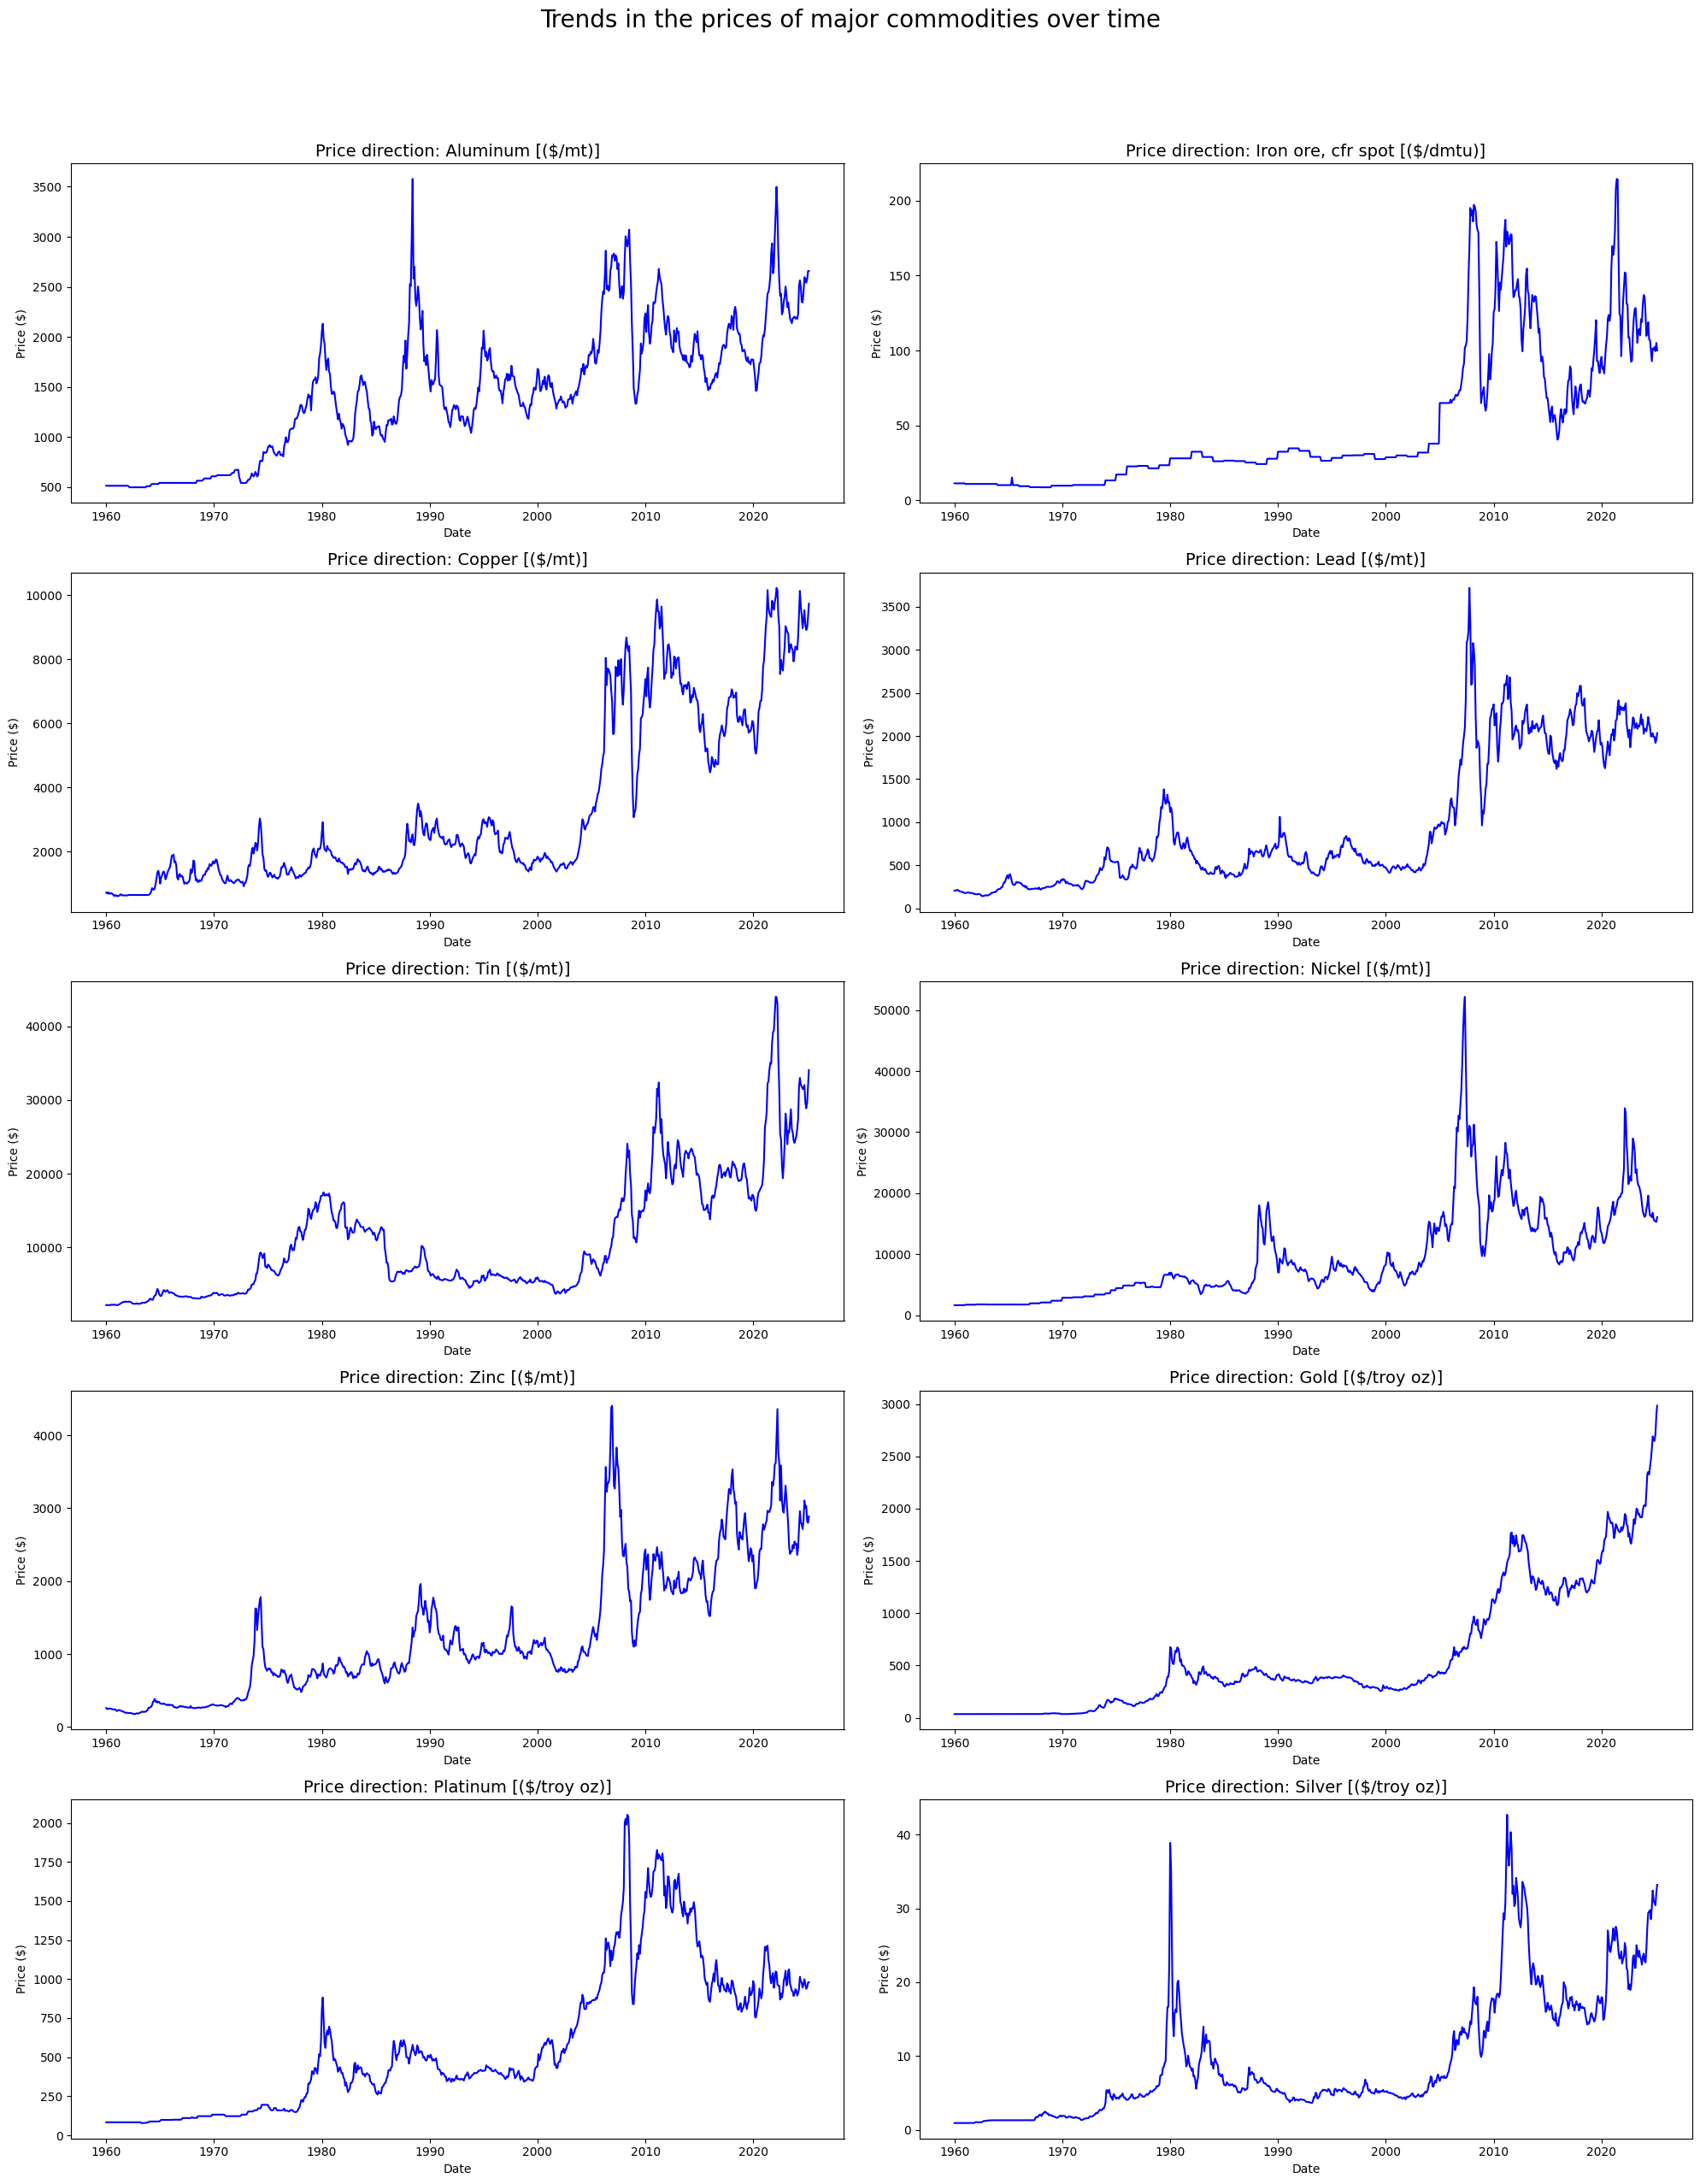

In [273]:
commodities_to_plot = df.columns[61:71]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.suptitle('Trends in the prices of major commodities over time', fontsize=20, y=1.02)

# إنشاء حلقة تكرارية (Loop) لرسم كل سلعة على حدة
for i, commodity in enumerate(commodities_to_plot):
    # تحديد مكان الرسم البياني في الشبكة
    ax = axes[i // 2, i % 2]

    # رسم المخطط
    ax.plot(df.index, df[commodity], color='b')
    ax.set_title(f'Price direction: {commodity}', fontsize=14)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')

# ضبط المسافات بين الرسوم البيانية
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

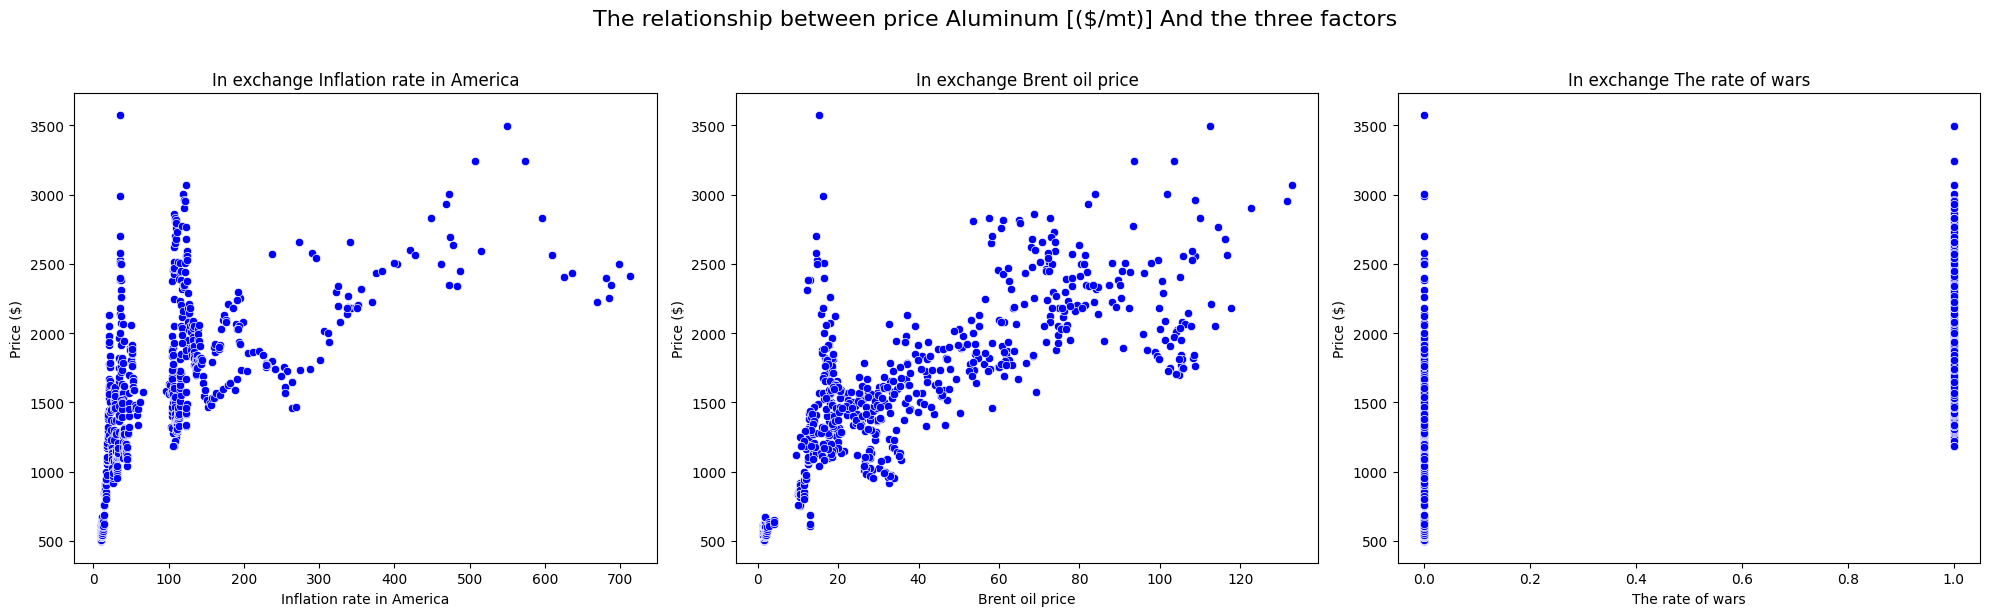

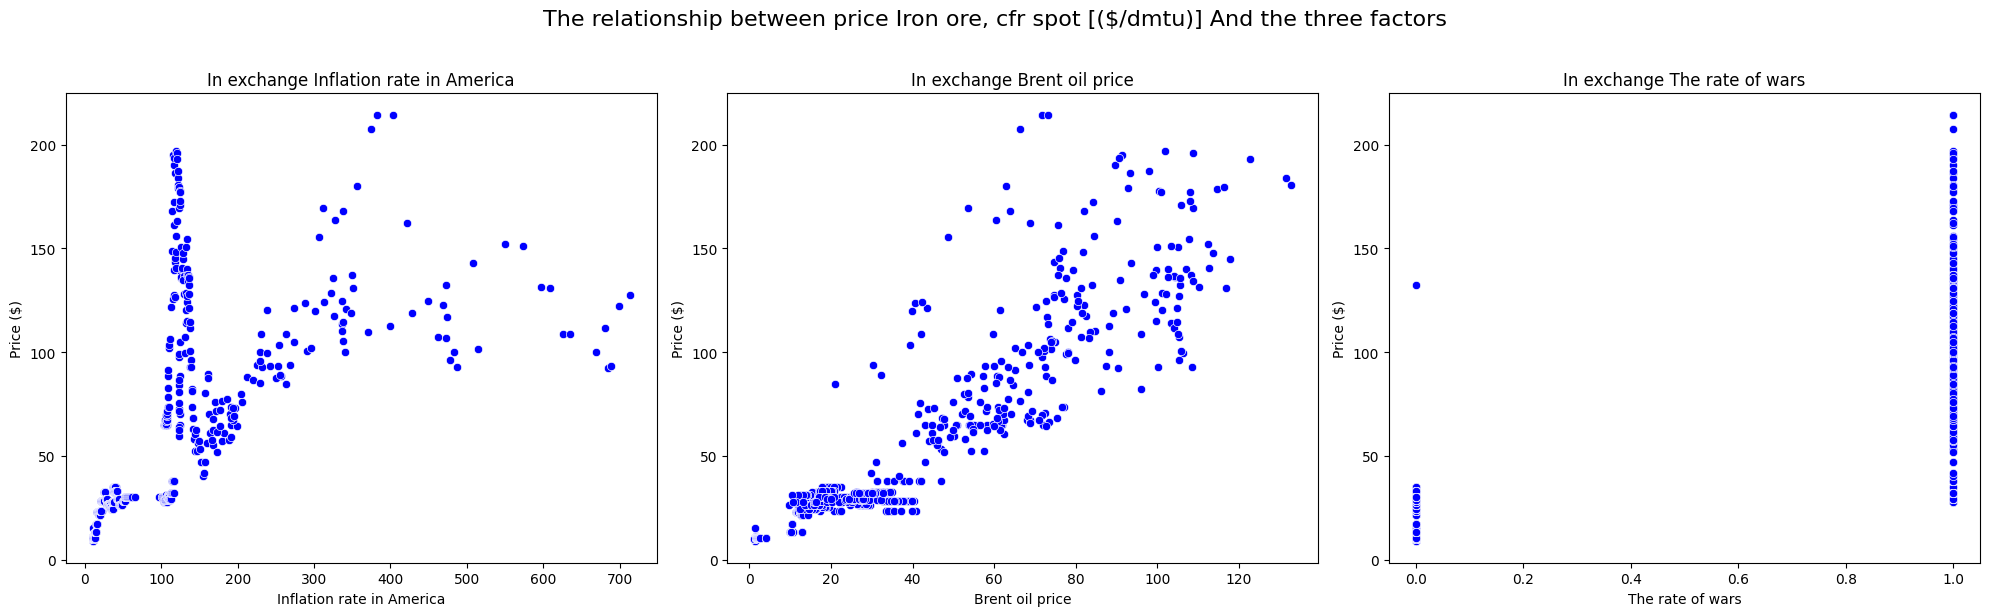

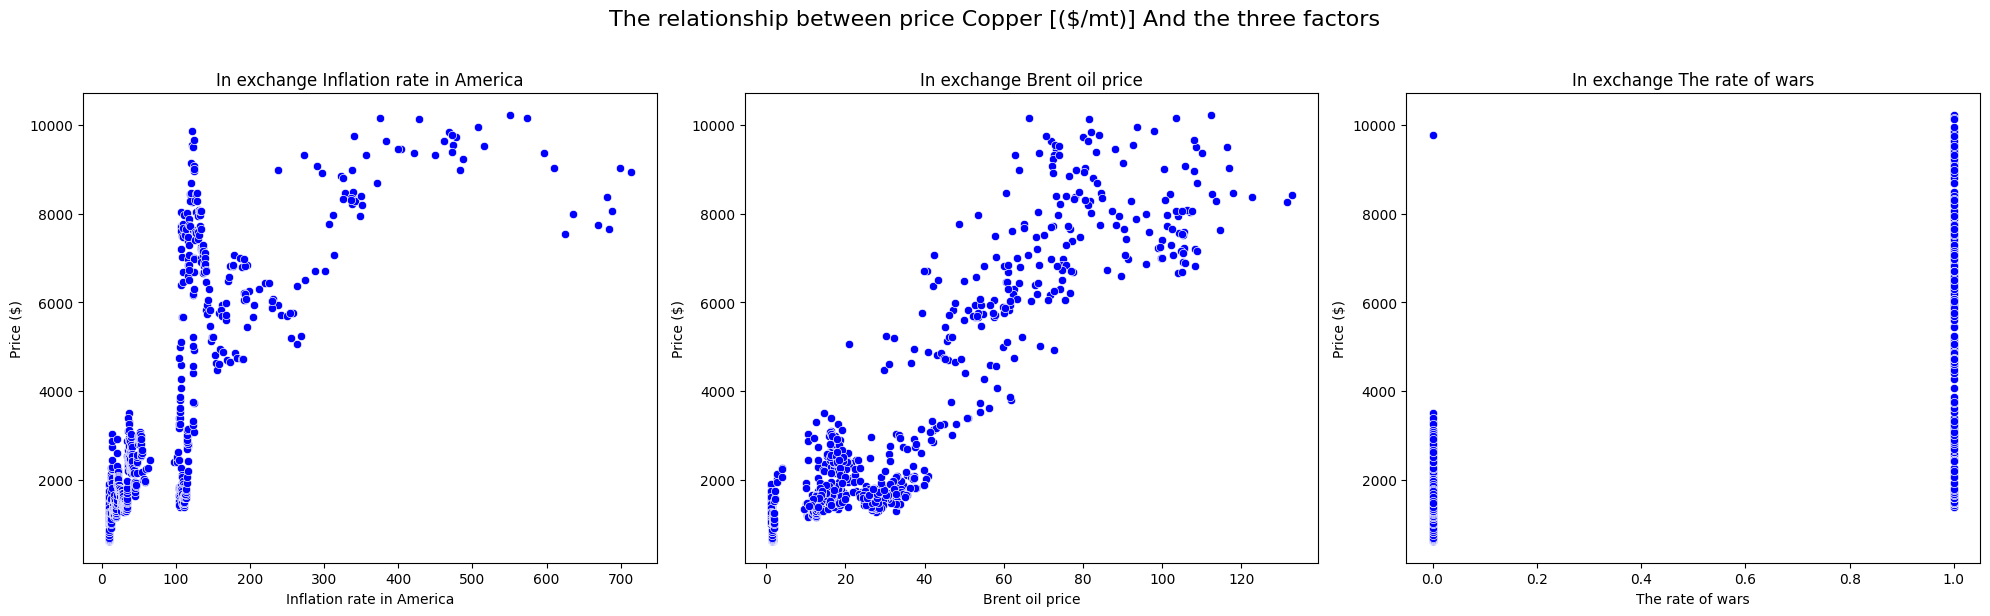

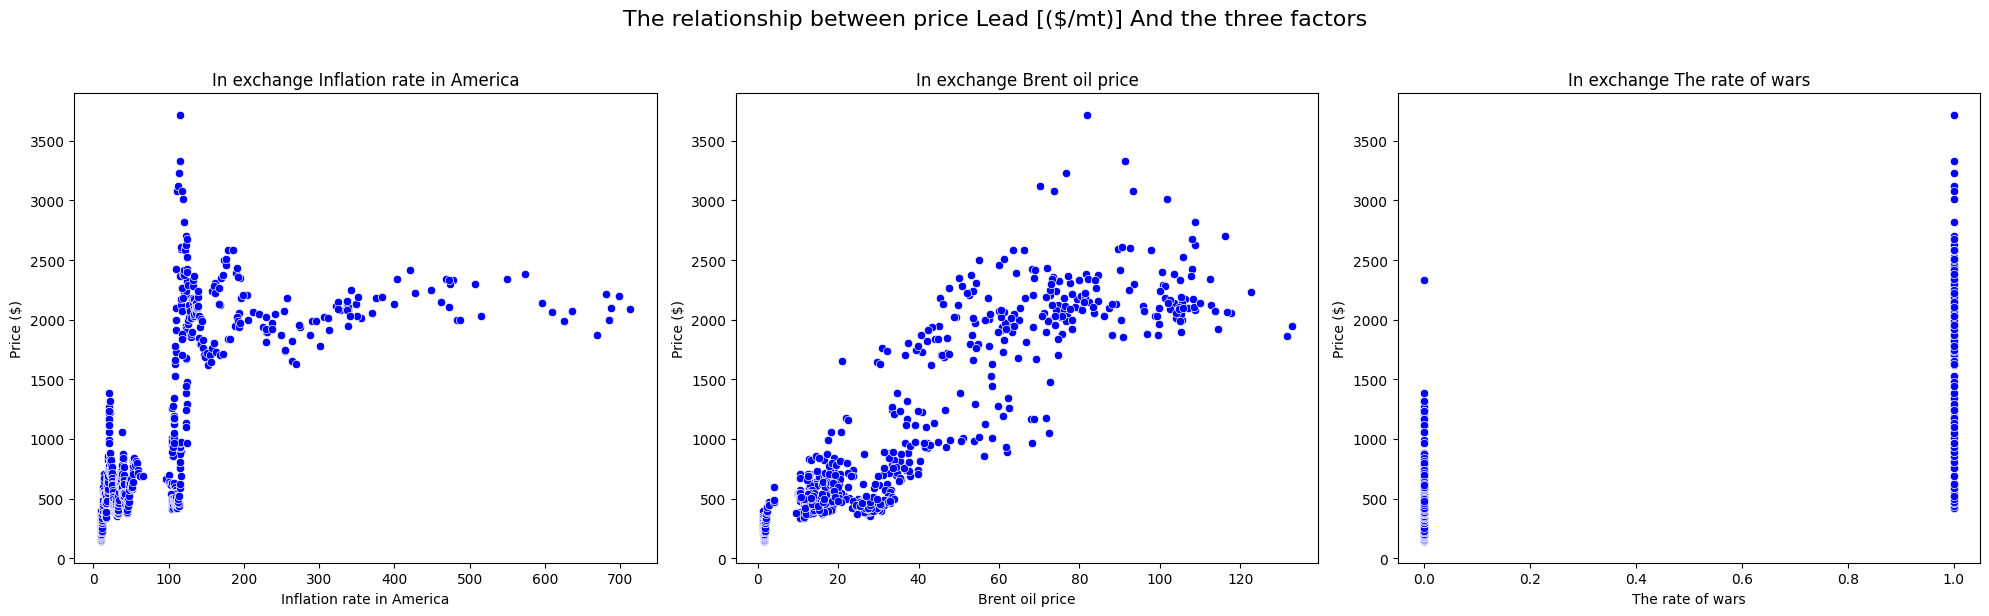

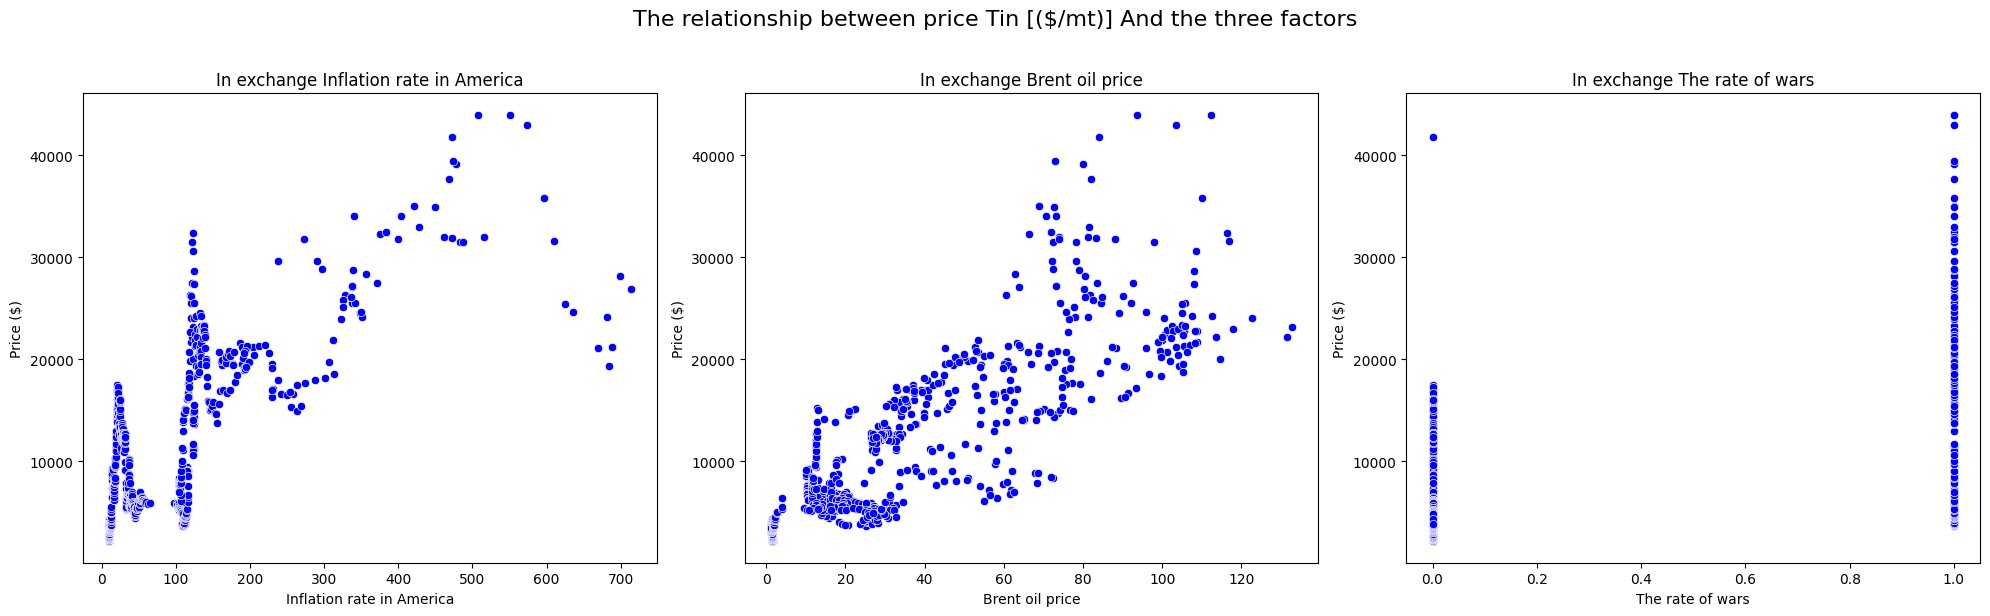

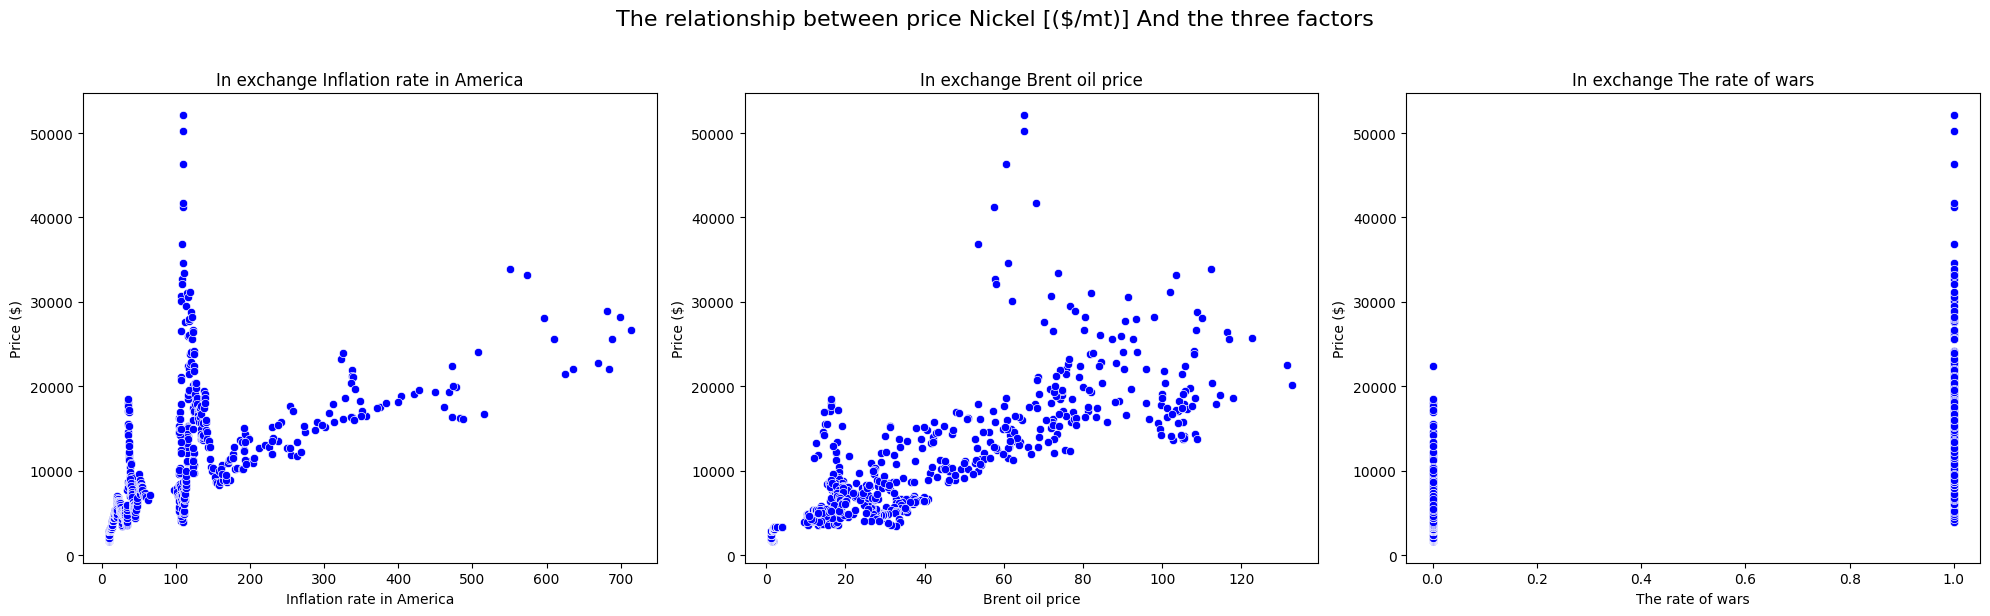

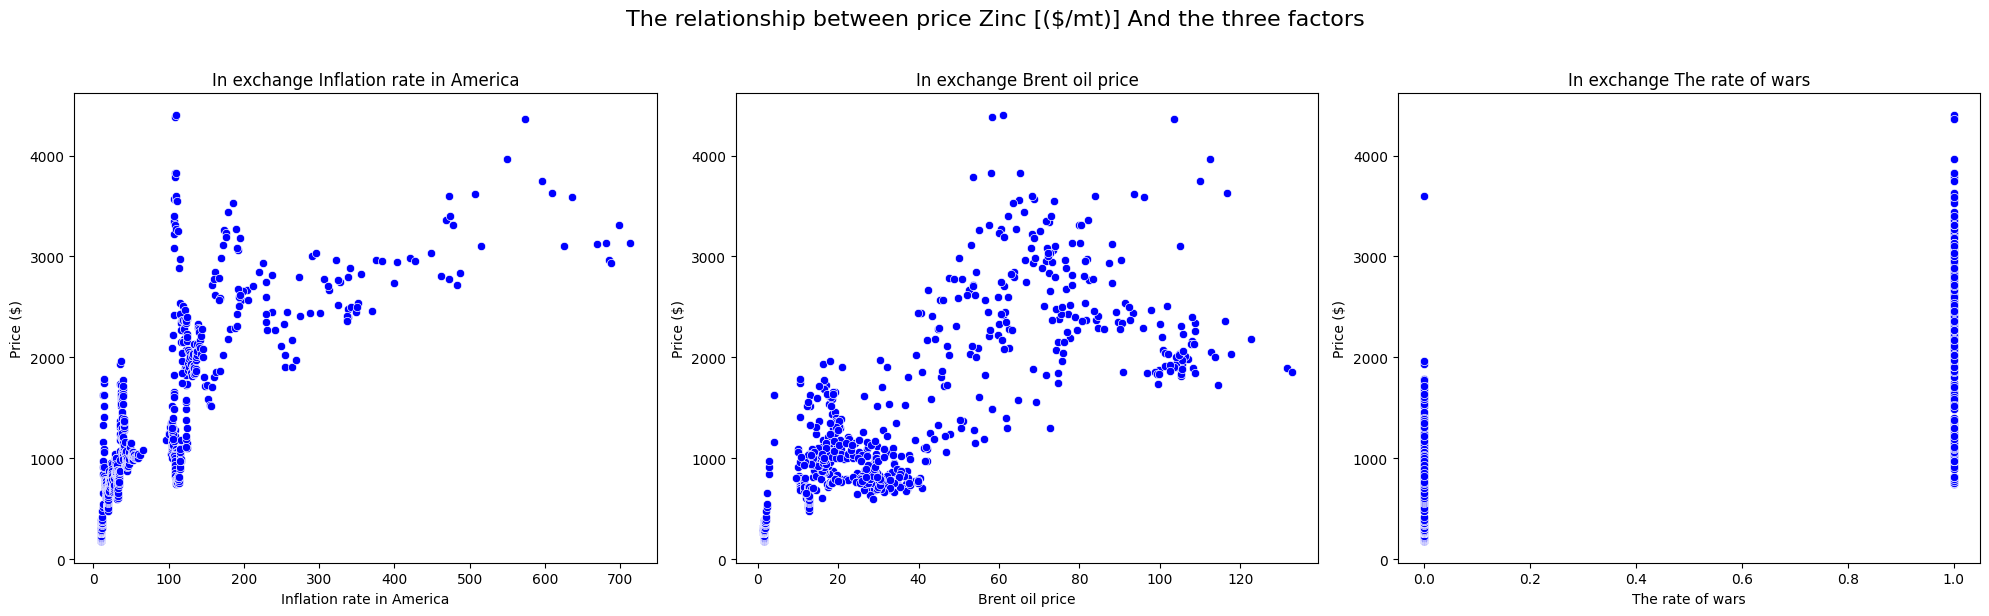

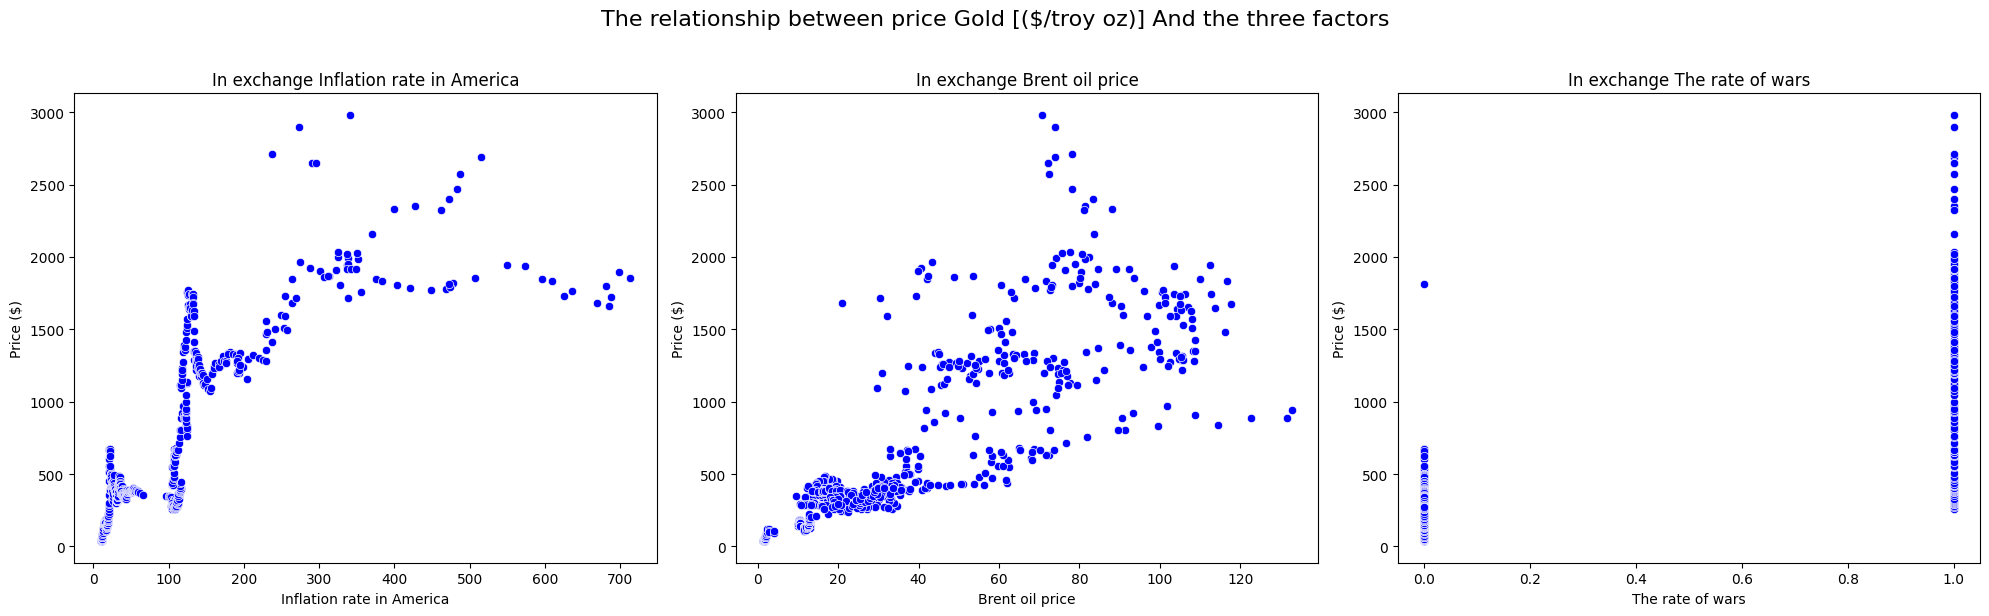

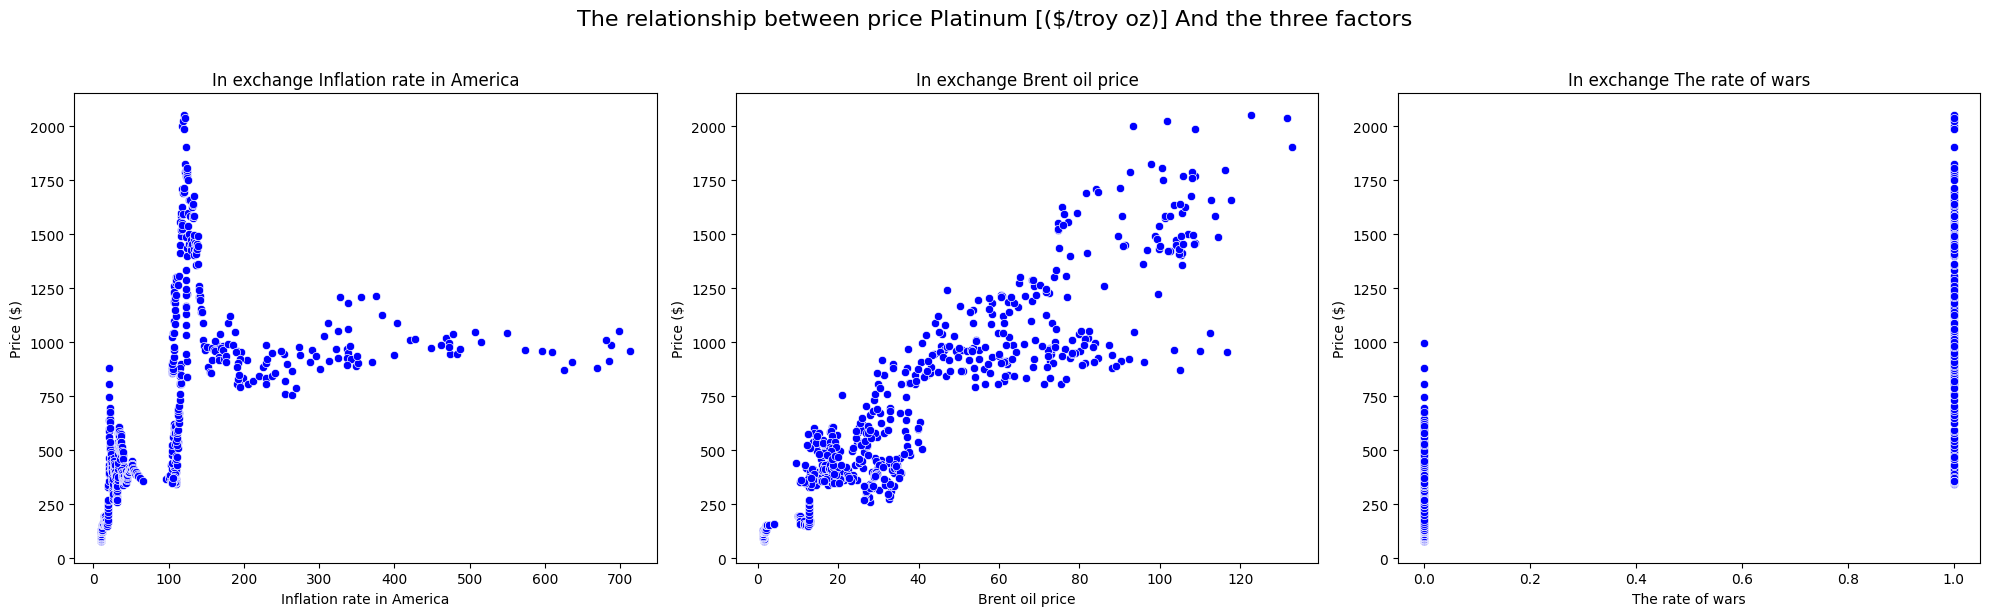

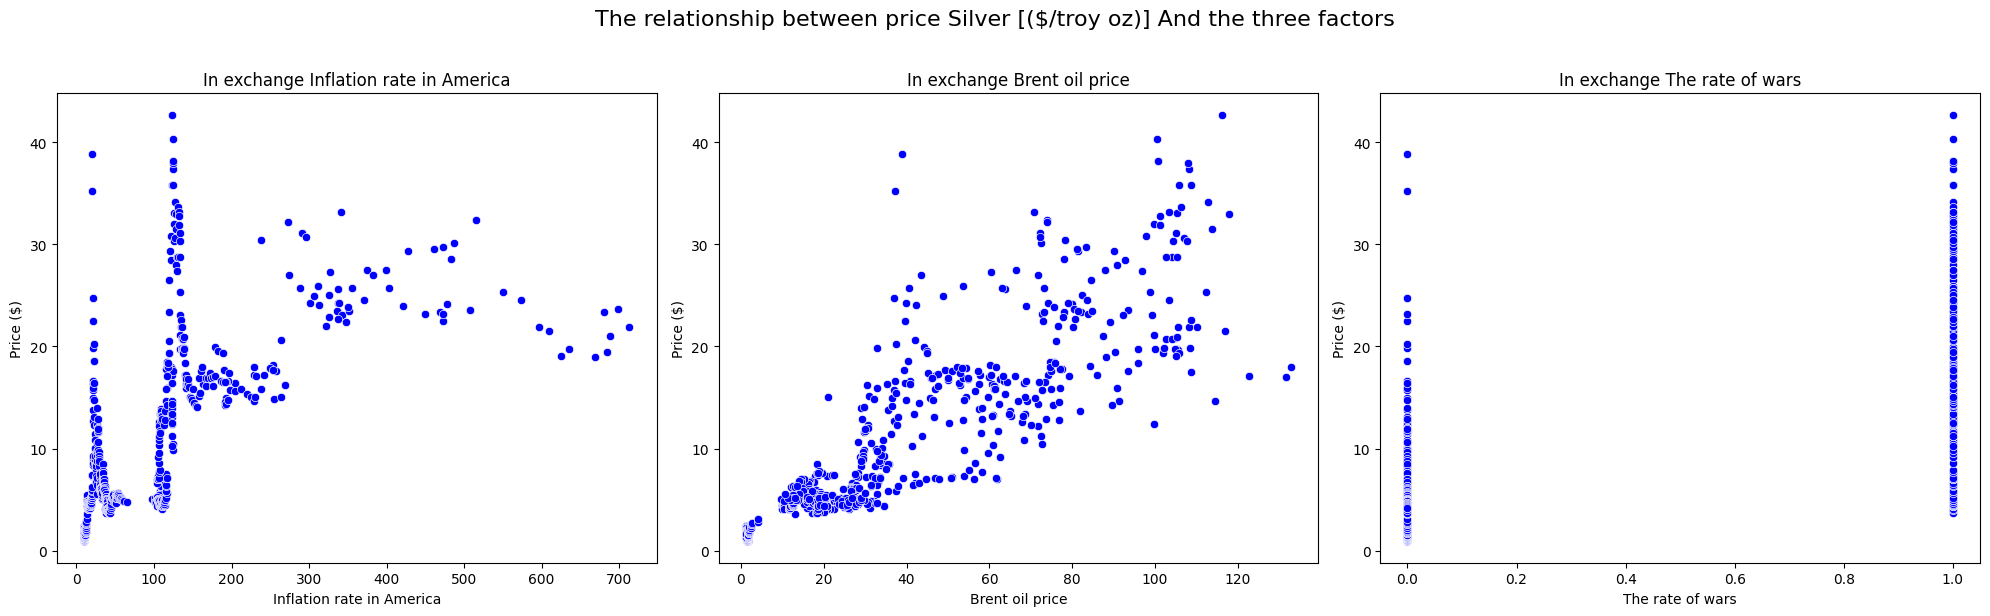

In [274]:
commodities_to_analyze = df.columns[61:71]

# تحديد العوامل الثلاثة
factors = {
    'Global_Inflation': 'Inflation rate in America',
    'Crude oil, average [($/bbl)]': 'Brent oil price',
    'War_Indicator': 'The rate of wars'
}


for commodity in commodities_to_analyze:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.suptitle(f'The relationship between price {commodity} And the three factors', fontsize=16, y=1.02)

    for i, (factor_col, factor_ar) in enumerate(factors.items()):
        ax = axes[i]

        sns.scatterplot(x=df[factor_col], y=df[commodity], ax=ax, color='b')

        ax.set_title(f'In exchange {factor_ar}', fontsize=12)
        ax.set_xlabel(f'{factor_ar}', fontsize=10)
        ax.set_ylabel('Price ($)', fontsize=10)

    plt.tight_layout()
    plt.show()

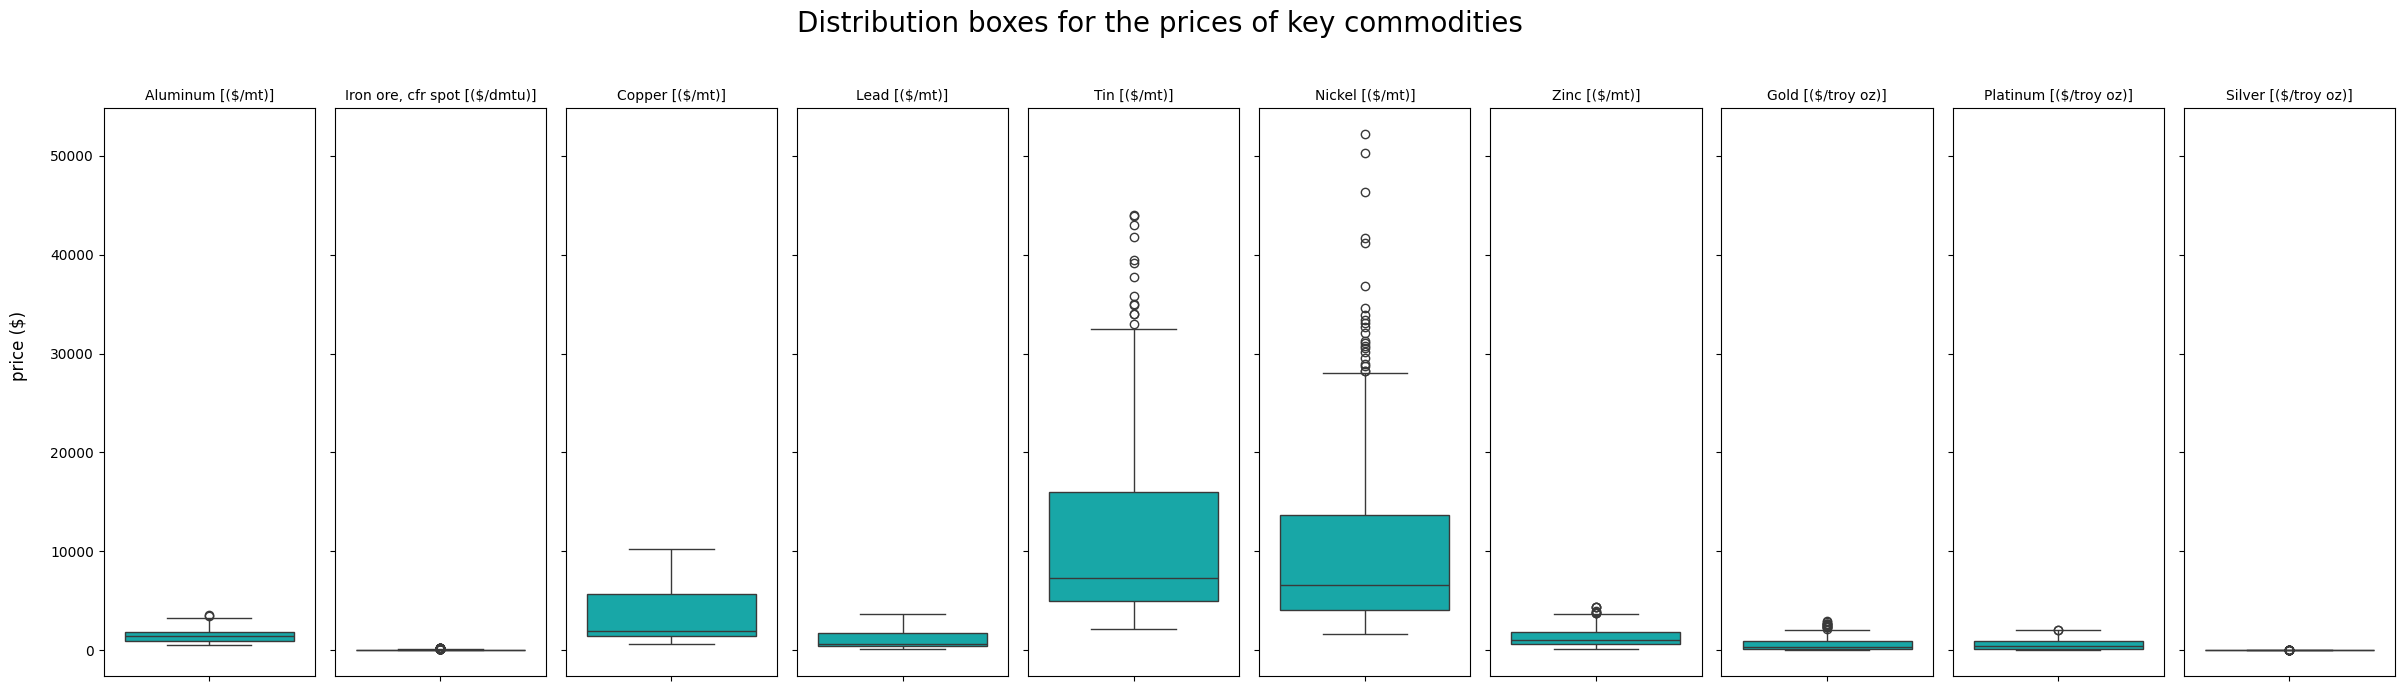

In [275]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(25, 7), sharey=True)
fig.suptitle('Distribution boxes for the prices of key commodities', fontsize=20)

for i, commodity in enumerate(commodities_to_plot):
    ax = axes[i]

    sns.boxplot(y=df[commodity], ax=ax, color='c')

    ax.set_title(commodity, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.text(0.04, 0.5, 'price ($)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.show()

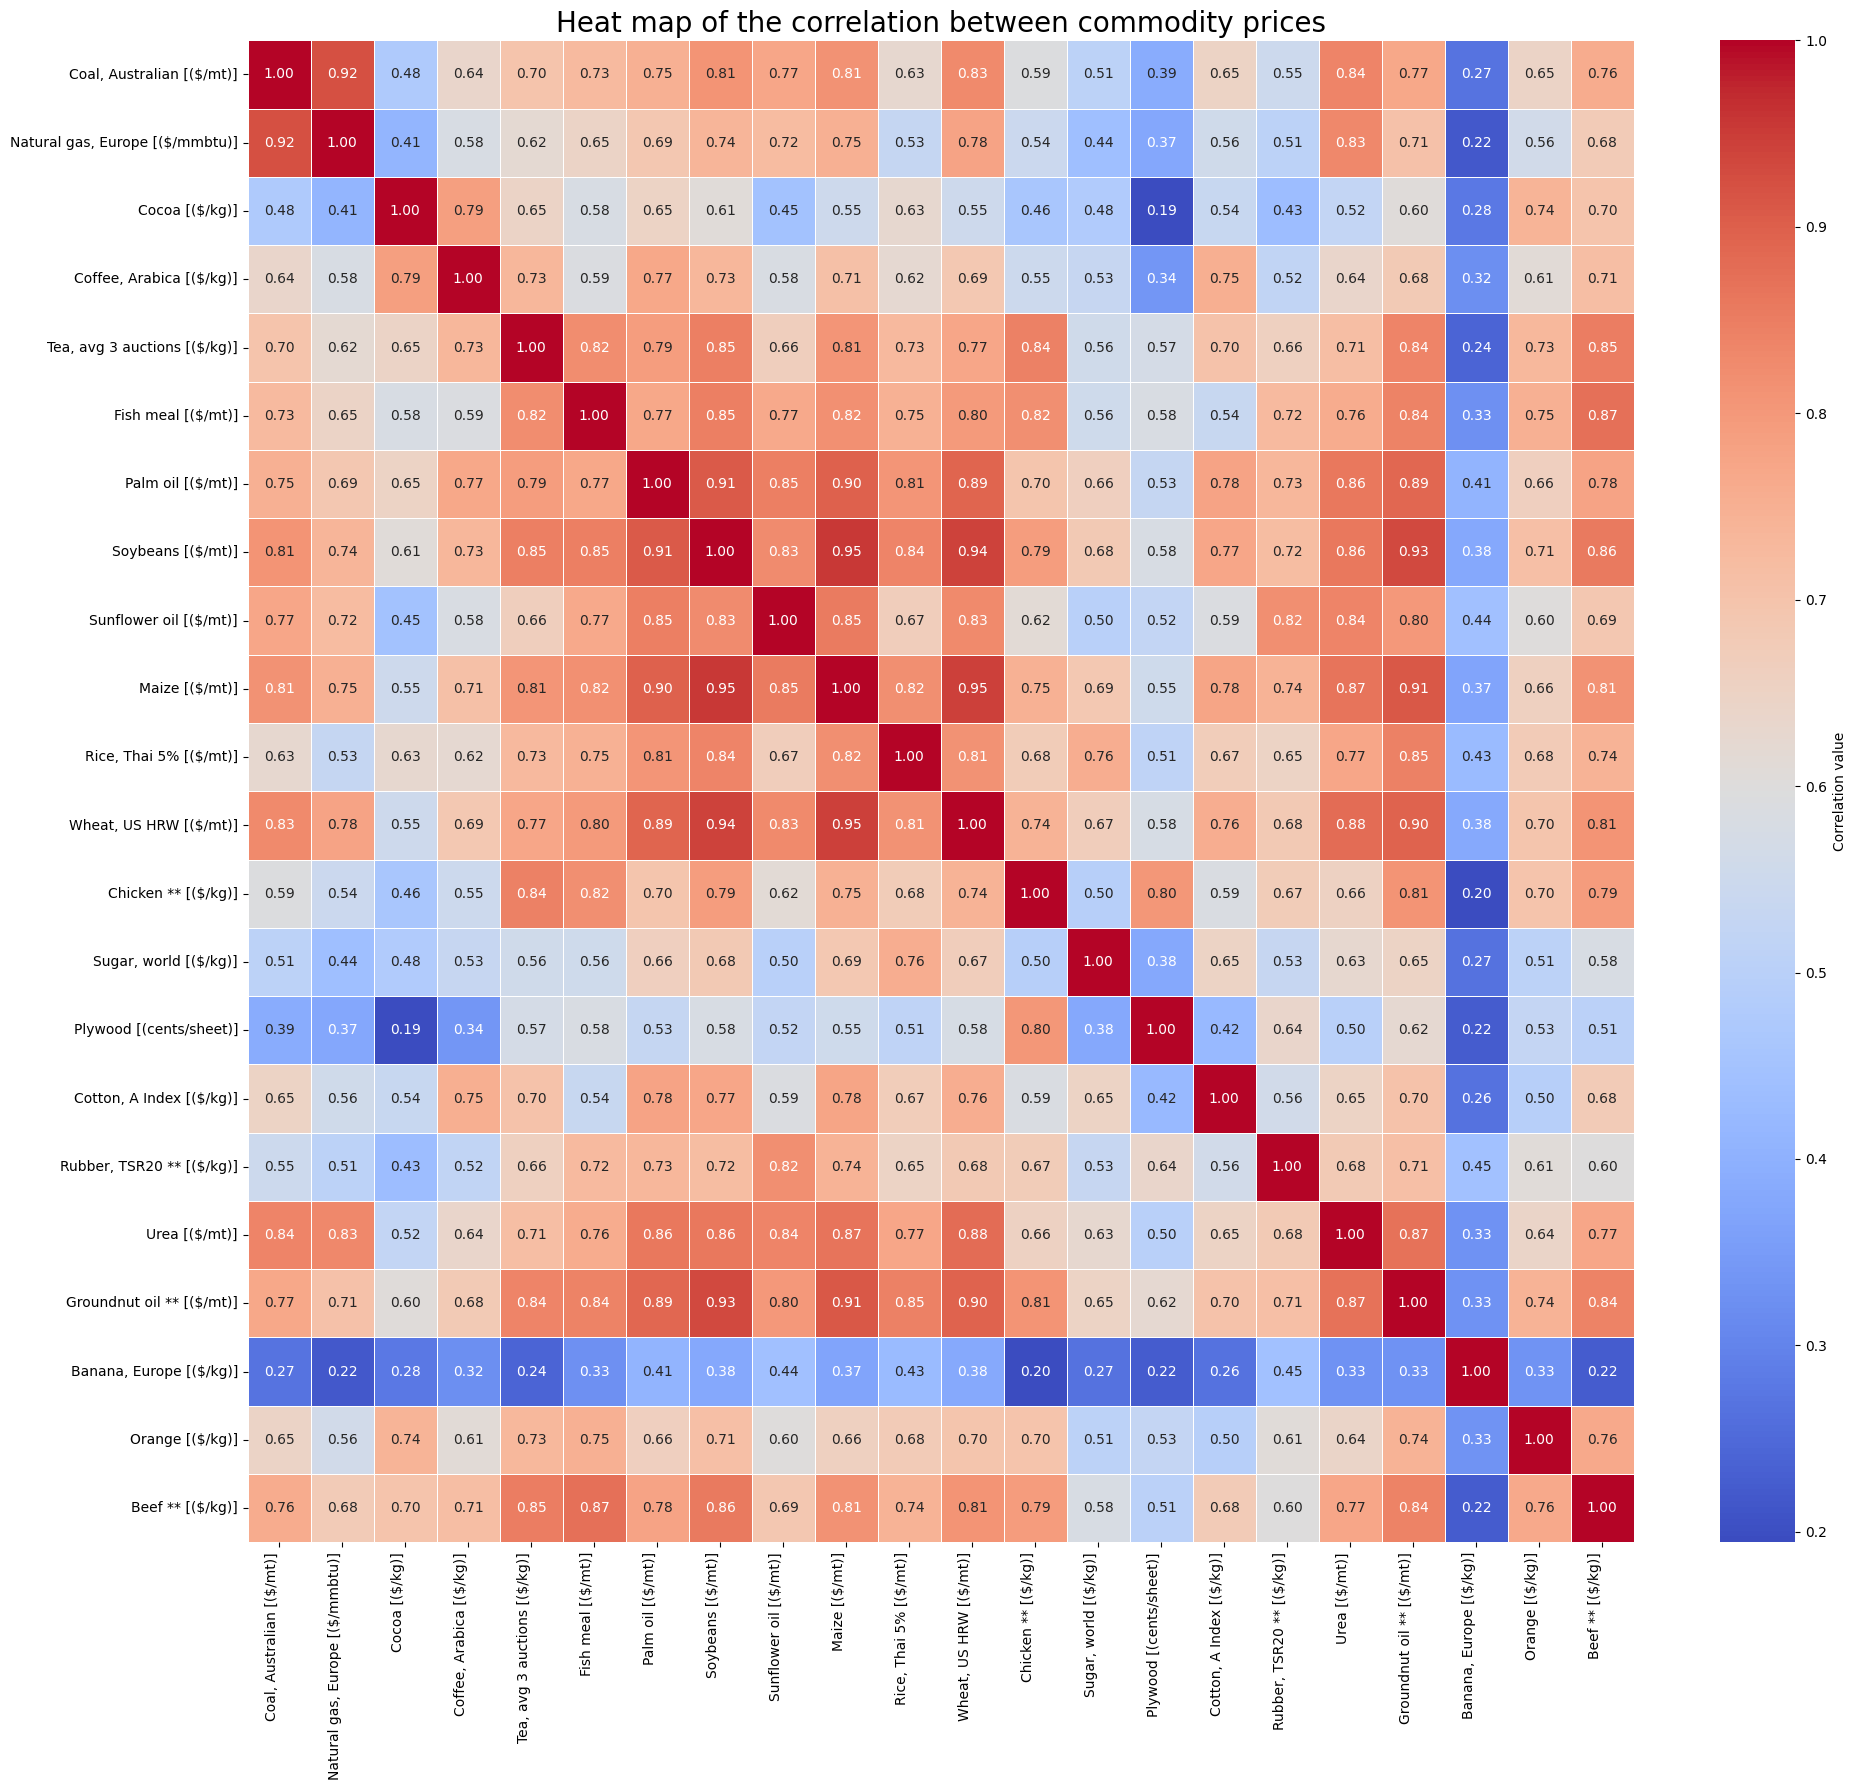

In [276]:
commodities_cols = [
    "Coal, Australian [($/mt)]",
    "Natural gas, Europe [($/mmbtu)]",
    "Cocoa [($/kg)]",
    "Coffee, Arabica [($/kg)]",
    "Tea, avg 3 auctions [($/kg)]",
    "Fish meal [($/mt)]",
    "Palm oil [($/mt)]",
    "Soybeans [($/mt)]",
    "Sunflower oil [($/mt)]",
    "Maize [($/mt)]",
    "Rice, Thai 5% [($/mt)]",
    "Wheat, US HRW [($/mt)]",
    "Chicken ** [($/kg)]",
    "Sugar, world [($/kg)]",
    "Plywood [(cents/sheet)]",
    "Cotton, A Index [($/kg)]",
    "Rubber, TSR20 ** [($/kg)]",
    "Urea [($/mt)]",
    "Groundnut oil ** [($/mt)]",
    "Banana, Europe [($/kg)]",
    "Orange [($/kg)]",
    "Beef ** [($/kg)]",
]

correlation_matrix = df[commodities_cols].corr()

# رسم خريطة الحرارة
plt.figure(figsize=(20, 18))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation value'}
)

plt.title('Heat map of the correlation between commodity prices', fontsize=20)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


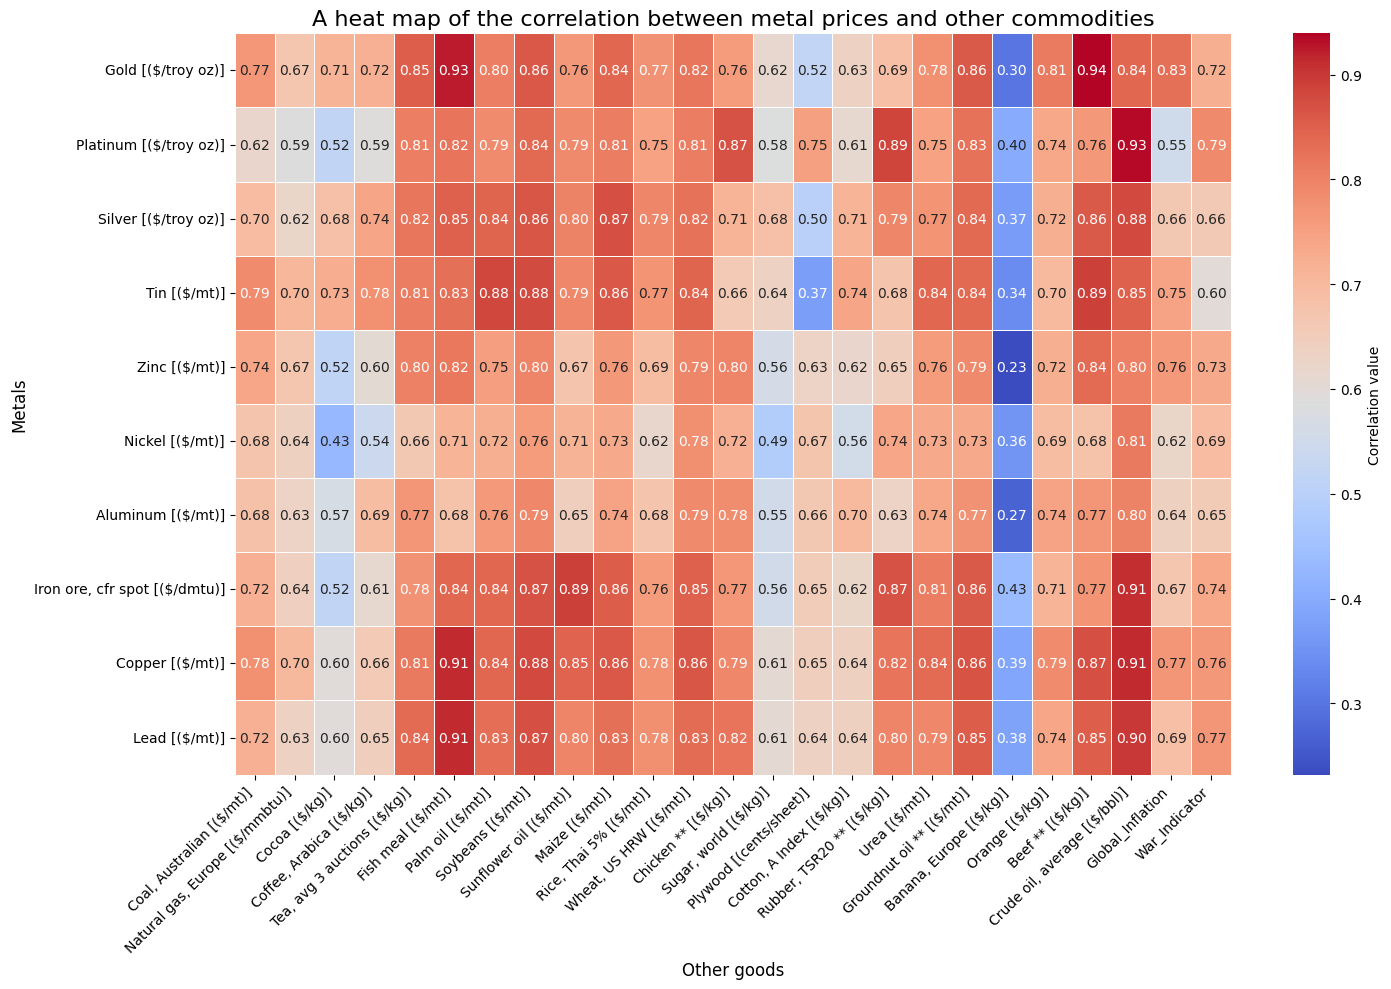

In [277]:
metals = [
    "Gold [($/troy oz)]"  ,
    "Platinum [($/troy oz)]",
    "Silver [($/troy oz)]",
    "Tin [($/mt)]",
    "Zinc [($/mt)]",
    "Nickel [($/mt)]",
    "Aluminum [($/mt)]",
    "Iron ore, cfr spot [($/dmtu)]",
    "Copper [($/mt)]",
    "Lead [($/mt)]"
]

other_commodities = [
    "Coal, Australian [($/mt)]",
    "Natural gas, Europe [($/mmbtu)]",
    "Cocoa [($/kg)]",
    "Coffee, Arabica [($/kg)]",
    "Tea, avg 3 auctions [($/kg)]",
    "Fish meal [($/mt)]",
    "Palm oil [($/mt)]",
    "Soybeans [($/mt)]",
    "Sunflower oil [($/mt)]",
    "Maize [($/mt)]",
    "Rice, Thai 5% [($/mt)]",
    "Wheat, US HRW [($/mt)]",
    "Chicken ** [($/kg)]",
    "Sugar, world [($/kg)]",
    "Plywood [(cents/sheet)]",
    "Cotton, A Index [($/kg)]",
    "Rubber, TSR20 ** [($/kg)]",
    "Urea [($/mt)]",
    "Groundnut oil ** [($/mt)]",
    "Banana, Europe [($/kg)]",
    "Orange [($/kg)]",
    "Beef ** [($/kg)]",
    "Crude oil, average [($/bbl)]",
    "Global_Inflation",
    "War_Indicator"
]

all_cols = metals + other_commodities

correlation_matrix = df[all_cols].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(
    correlation_matrix.loc[metals, other_commodities],
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation value'}
)

plt.title('A heat map of the correlation between metal prices and other commodities', fontsize=16)
plt.xlabel('Other goods', fontsize=12)
plt.ylabel('Metals', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


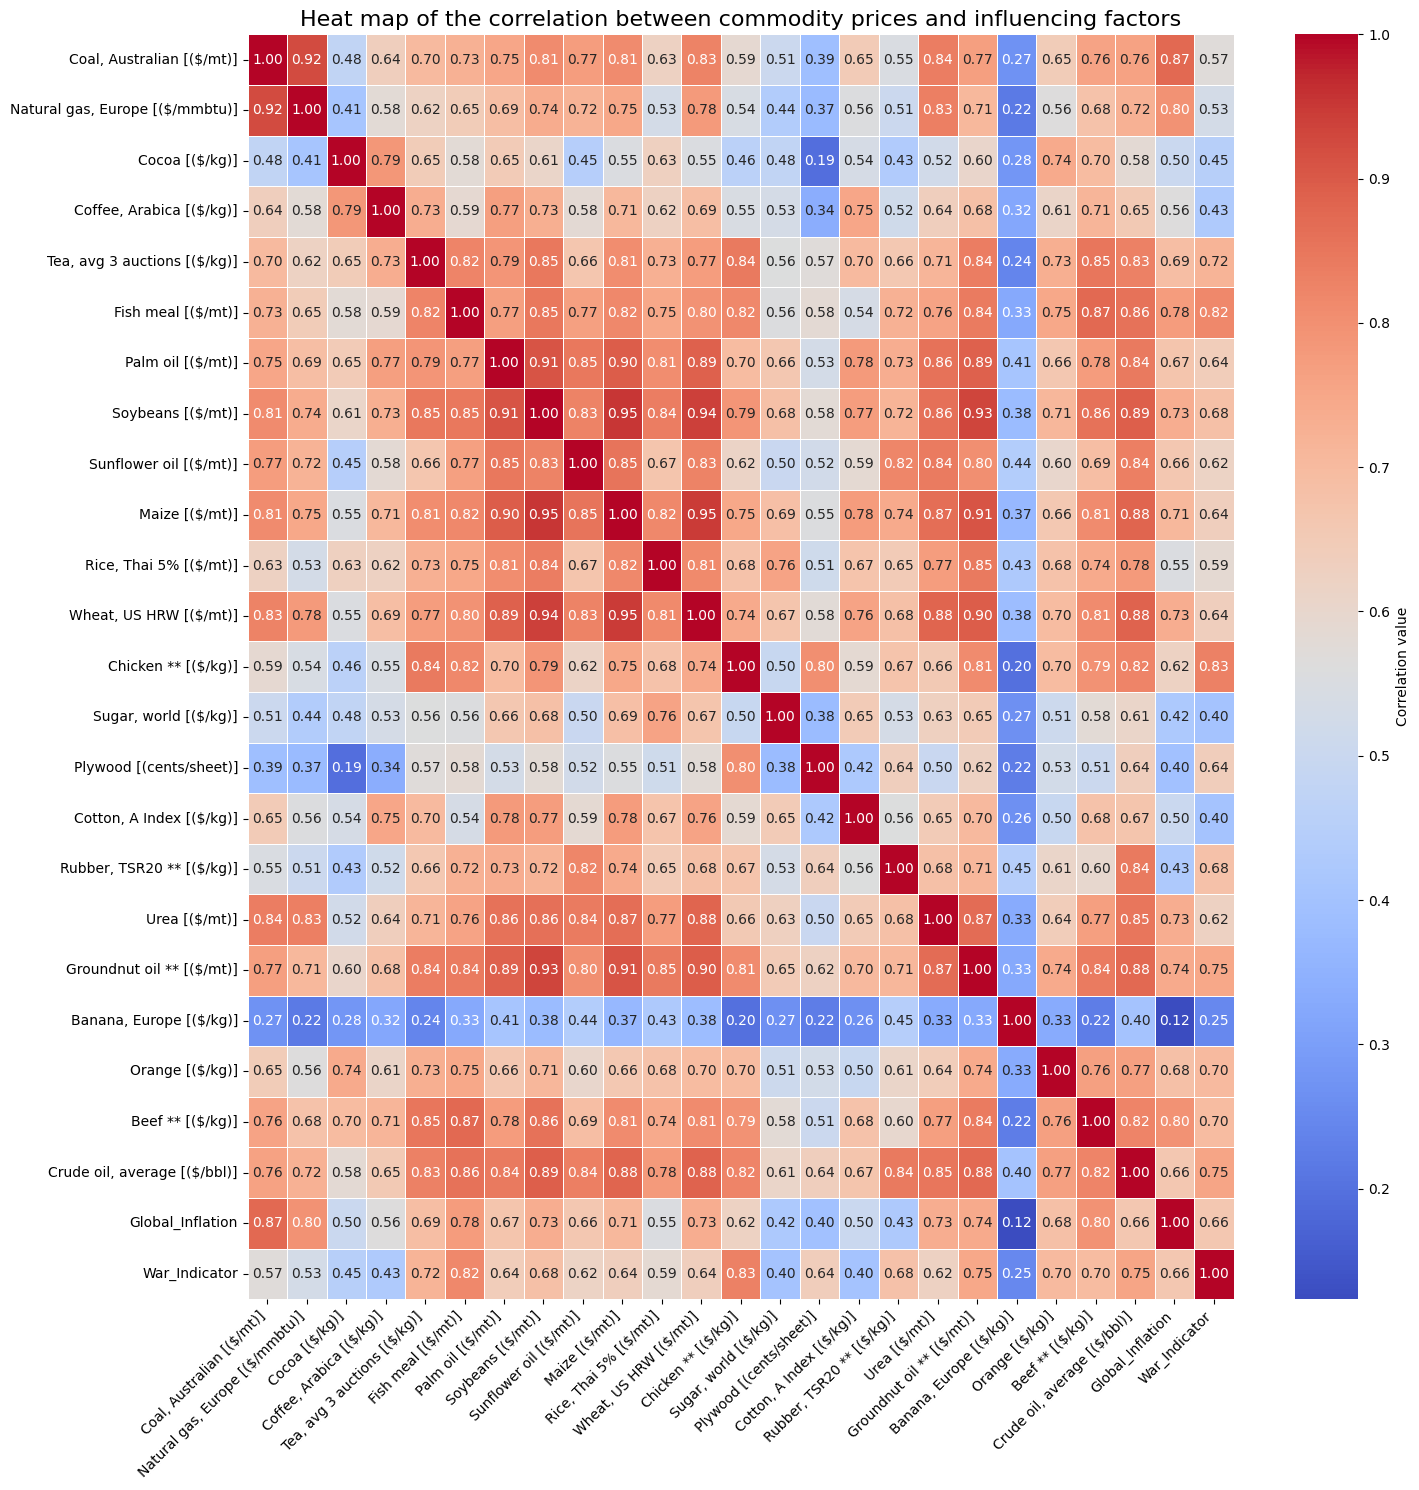

In [278]:
selected_columns = [
  "Coal, Australian [($/mt)]",
    "Natural gas, Europe [($/mmbtu)]",
    "Cocoa [($/kg)]",
    "Coffee, Arabica [($/kg)]",
    "Tea, avg 3 auctions [($/kg)]",
    "Fish meal [($/mt)]",
    "Palm oil [($/mt)]",
    "Soybeans [($/mt)]",
    "Sunflower oil [($/mt)]",
    "Maize [($/mt)]",
    "Rice, Thai 5% [($/mt)]",
    "Wheat, US HRW [($/mt)]",
    "Chicken ** [($/kg)]",
    "Sugar, world [($/kg)]",
    "Plywood [(cents/sheet)]",
    "Cotton, A Index [($/kg)]",
    "Rubber, TSR20 ** [($/kg)]",
    "Urea [($/mt)]",
    "Groundnut oil ** [($/mt)]",
    "Banana, Europe [($/kg)]",
    "Orange [($/kg)]",
    "Beef ** [($/kg)]",
    "Crude oil, average [($/bbl)]",
    "Global_Inflation",
    "War_Indicator"
]

correlation_matrix = df[selected_columns].corr()

plt.figure(figsize=(15, 15))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation value'}
)

plt.title('Heat map of the correlation between commodity prices and influencing factors', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [279]:
df

Crude oil, average [($/bbl)]  Crude oil, Brent [($/bbl)]  \
Date                                                                   
1960-01-01                      1.630000                       1.630   
1960-02-01                      1.630000                       1.630   
1960-03-01                      1.630000                       1.630   
1960-04-01                      1.630000                       1.630   
1960-05-01                      1.630000                       1.630   
...                                  ...                         ...   
2024-11-01                     72.291667                      74.395   
2024-12-01                     72.311000                      73.833   
2025-01-01                     78.162000                      79.206   
2025-02-01                     73.819000                      75.157   
2025-03-01                     70.701333                      72.574   

            Crude oil, Dubai [($/bbl)]  Crude oil, WTI [($/bbl)]  \
Date                                                               
1960-01-01                        1.63                     35.30   
1960-02-01                        1.63                     35.30   
1960-03-01                        1.63                     35.30   
1960-04-01                        1.63                     35.30   
1960-05-01                        1.63                     35.30   
...                                ...                       ...   
2024-11-01                       72.79                     69.69   
2024-12-01                       73.31                     69.79   
2025-01-01                       80.14                     75.14   
2025-02-01                       74.97                     71.33   
2025-03-01                       71.71                     67.82   

            Coal, Australian [($/mt)]  Coal, South African ** [($/mt)]  \
Date                                                                     
1960-01-01                       7.80                            29.34   
1960-02-01                       7.80                            29.34   
1960-03-01                       7.80                            29.34   
1960-04-01                       7.80                            29.34   
1960-05-01                       7.80                            29.34   
...                               ...                              ...   
2024-11-01                     142.12                           106.82   
2024-12-01                     129.81                           105.47   
2025-01-01                     118.60                           103.28   
2025-02-01                     106.93                           100.41   
2025-03-01                     103.97                            97.99   

            Natural gas, US [($/mmbtu)]  Natural gas, Europe [($/mmbtu)]  \
Date                                                                       
1960-01-01                       0.1400                         0.404774   
1960-02-01                       0.1400                         0.404774   
1960-03-01                       0.1400                         0.404774   
1960-04-01                       0.1400                         0.404774   
1960-05-01                       0.1400                         0.404774   
...                                 ...                              ...   
2024-11-01                       2.1045                        13.926400   
2024-12-01                       3.0229                        13.856621   
2025-01-01                       4.0991                        14.663512   
2025-02-01                       4.2226                        15.340532   
2025-03-01                       4.1281                        13.235407   

            Liquefied natural gas, Japan [($/mmbtu)]  \
Date                                                   
1960-01-01                                  2.771163   
1960-02-01                                  2.771163   
1960-03-01    

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 1960-01-01 to 2025-03-01
Data columns (total 80 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Crude oil, average [($/bbl)]              783 non-null    float64
 1   Crude oil, Brent [($/bbl)]                783 non-null    float64
 2   Crude oil, Dubai [($/bbl)]                783 non-null    float64
 3   Crude oil, WTI [($/bbl)]                  783 non-null    float64
 4   Coal, Australian [($/mt)]                 783 non-null    float64
 5   Coal, South African ** [($/mt)]           783 non-null    float64
 6   Natural gas, US [($/mmbtu)]               783 non-null    float64
 7   Natural gas, Europe [($/mmbtu)]           783 non-null    float64
 8   Liquefied natural gas, Japan [($/mmbtu)]  783 non-null    float64
 9   Natural gas index [(2010=100)]            783 non-null    float64
 10  Cocoa [($/kg)]     

In [281]:
df['War_Name'].value_counts()

War_Name
No_War                     469
Afghanistan_War             92
Iraq_War                    84
Arab_Spring                 24
COVID19                     22
Russia_Ukraine_War          20
Gaza_War                    18
Kosovo_War                  17
Ukraine_Crimea              11
Global_Financial_Crisis     10
Gulf_War                     8
Asia_Financial_Crisis        7
9_11_Attacks                 1
Name: count, dtype: int64

In [282]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['War_Name'] = le.fit_transform(df['War_Name'])

In [283]:

df.isna().sum()

Crude oil, average [($/bbl)]         0
Crude oil, Brent [($/bbl)]           0
Crude oil, Dubai [($/bbl)]           0
Crude oil, WTI [($/bbl)]             0
Coal, Australian [($/mt)]            0
                                    ..
Nickel [($/mt)]_pct_change           1
Zinc [($/mt)]_pct_change             1
Gold [($/troy oz)]_pct_change        1
Platinum [($/troy oz)]_pct_change    1
Silver [($/troy oz)]_pct_change      1
Length: 80, dtype: int64

In [284]:
df.dropna(inplace=True)

# Data Splitting

In [285]:
X = df.drop(["Aluminum [($/mt)]",
    "Iron ore, cfr spot [($/dmtu)]",
    "Copper [($/mt)]",
    "Lead [($/mt)]",
    "Tin [($/mt)]",
    "Nickel [($/mt)]",
    "Zinc [($/mt)]",
    "Gold [($/troy oz)]",
    "Platinum [($/troy oz)]",
    "Silver [($/troy oz)]"], axis=1)

y = df[["Aluminum [($/mt)]",
    "Iron ore, cfr spot [($/dmtu)]",
    "Copper [($/mt)]",
    "Lead [($/mt)]",
    "Tin [($/mt)]",
    "Nickel [($/mt)]",
    "Zinc [($/mt)]",
    "Gold [($/troy oz)]",
    "Platinum [($/troy oz)]",
    "Silver [($/troy oz)]"]] 

In [286]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Scaling

In [287]:
from sklearn.preprocessing import StandardScaler

# Scale X
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns

scaler_X = StandardScaler()
X_train[numeric_cols] = scaler_X.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_X.transform(X_test[numeric_cols])

# Scale y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)  
y_test = scaler_y.transform(y_test)


# MODEL TRAINING

1) Linear Regression

In [389]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [390]:
y_pred_original = scaler_y.inverse_transform(y_pred)
y_original = scaler_y.inverse_transform(y)
y_test_original = scaler_y.inverse_transform(y_test)

In [391]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for i in range(y_test_original.shape[1]):
    mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
    print(f"Target {i+1}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")

Target 1: MSE=42210.56, MAE=143.99, R²=0.8990
Target 2: MSE=91.28, MAE=6.57, R²=0.9545
Target 3: MSE=191810.51, MAE=332.22, R²=0.9743
Target 4: MSE=25079.41, MAE=112.15, R²=0.9553
Target 5: MSE=2063947.38, MAE=1041.86, R²=0.9709
Target 6: MSE=7601934.72, MAE=1959.21, R²=0.8398
Target 7: MSE=90833.14, MAE=217.68, R²=0.8894
Target 8: MSE=5896.95, MAE=51.61, R²=0.9848
Target 9: MSE=4391.12, MAE=49.52, R²=0.9790
Target 10: MSE=2.65, MAE=1.15, R²=0.9649


In [392]:


mse = mean_squared_error(y_test_original, y_pred_original, multioutput='uniform_average')
mae = mean_absolute_error(y_test_original, y_pred_original, multioutput='uniform_average')
r2_lr = r2_score(y_test_original, y_pred_original, multioutput='uniform_average')

print(f"Overall MSE: {mse:.2f}")
print(f"Overall MAE: {mae:.2f}")
print(f"Overall R²: {r2_lr:.4f}")

Overall MSE: 1002619.77
Overall MAE: 391.60
Overall R²: 0.9412


2) SVM

In [393]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



# نعمل pipeline: scaling -> SVR
svr = SVR()

# param grid للـ SVR
param_grid = {
    "estimator__C": [0.1, 1, 10],
    "estimator__kernel": ["linear", "rbf", "poly"],
    "estimator__gamma": ["scale", "auto"]
}

# MultiOutput مع GridSearchCV
multi_output_svr = MultiOutputRegressor(svr)

grid_search = GridSearchCV(
    multi_output_svr,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=4
)

# تدريب
grid_search.fit(X_train, y_train)

# أفضل باراميترات
print("Best Params:", grid_search.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}


In [394]:
y_pred = grid_search.predict(X_test)


In [395]:
y_pred_original = scaler_y.inverse_transform(y_pred)
y_original = scaler_y.inverse_transform(y)
y_test_original = scaler_y.inverse_transform(y_test)

In [396]:


for i in range(y_test_original.shape[1]):
    mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
    print(f"Target {i+1}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")


Target 1: MSE=10612.42, MAE=78.35, R²=0.9746
Target 2: MSE=41.47, MAE=4.21, R²=0.9793
Target 3: MSE=79440.10, MAE=215.00, R²=0.9894
Target 4: MSE=8946.06, MAE=71.85, R²=0.9841
Target 5: MSE=1167086.83, MAE=819.33, R²=0.9836
Target 6: MSE=2033380.67, MAE=860.28, R²=0.9571
Target 7: MSE=16306.17, MAE=92.16, R²=0.9802
Target 8: MSE=2767.61, MAE=38.90, R²=0.9928
Target 9: MSE=2119.31, MAE=35.86, R²=0.9898
Target 10: MSE=1.58, MAE=0.80, R²=0.9791


In [397]:
mse = mean_squared_error(y_test_original, y_pred_original, multioutput='uniform_average')
mae = mean_absolute_error(y_test_original, y_pred_original, multioutput='uniform_average')
r2_svm = r2_score(y_test_original, y_pred_original, multioutput='uniform_average')

print(f"Overall MSE: {mse:.2f}")
print(f"Overall MAE: {mae:.2f}")
print(f"Overall R²: {r2_svm:.4f}")

Overall MSE: 332070.22
Overall MAE: 221.67
Overall R²: 0.9810


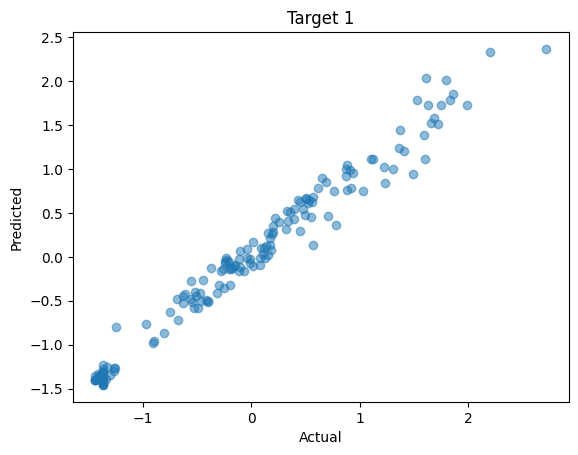

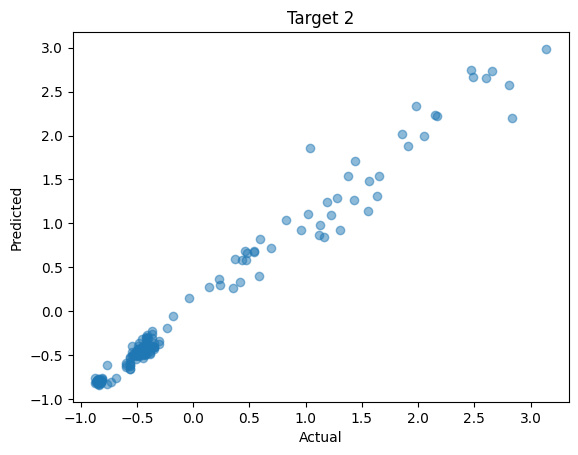

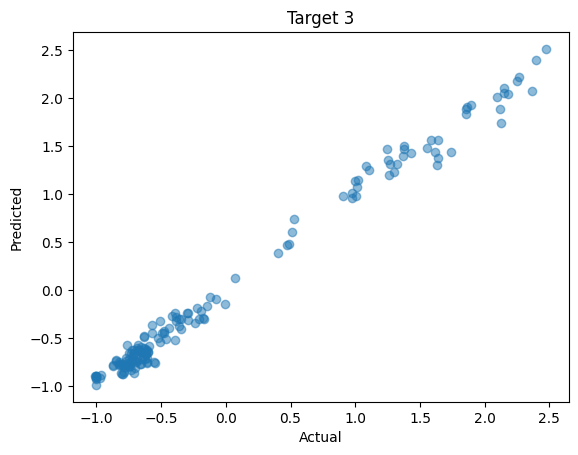

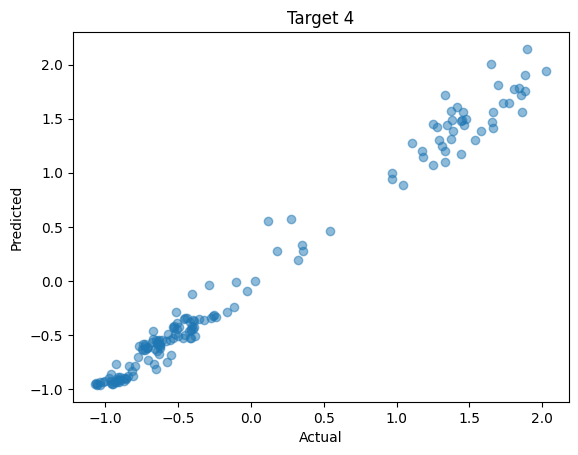

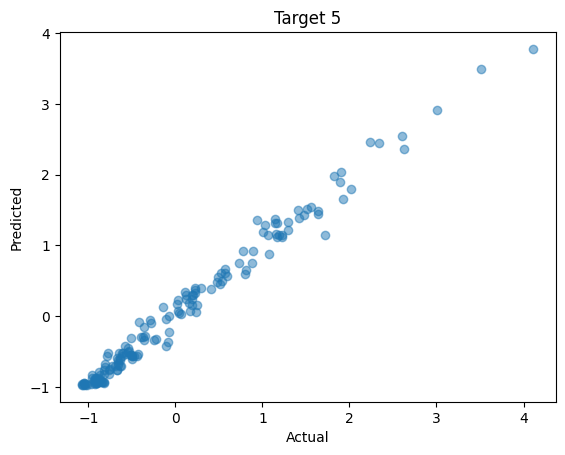

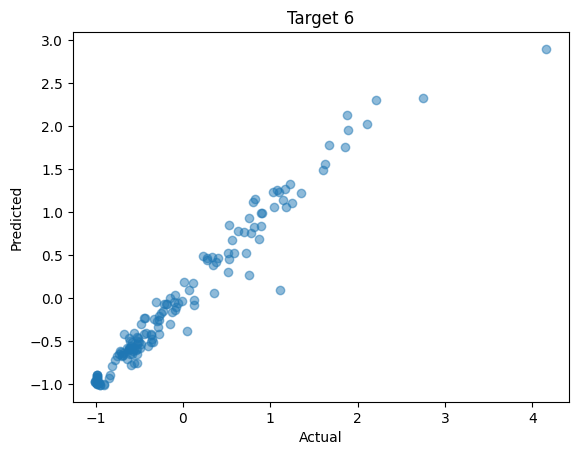

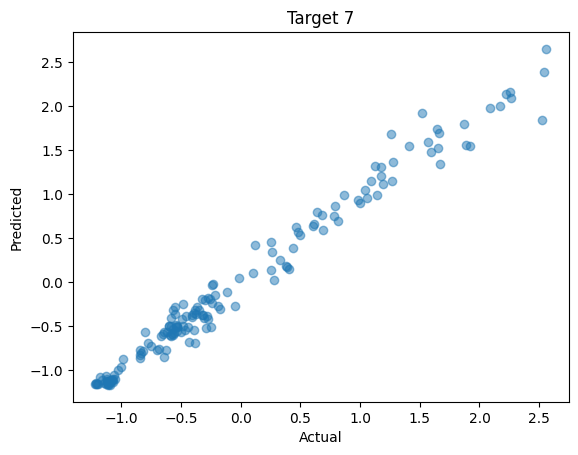

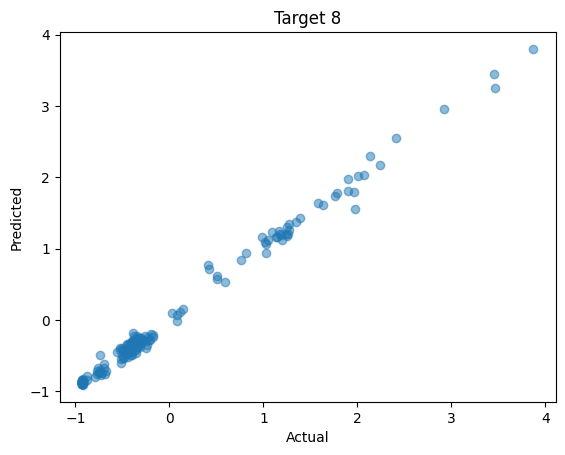

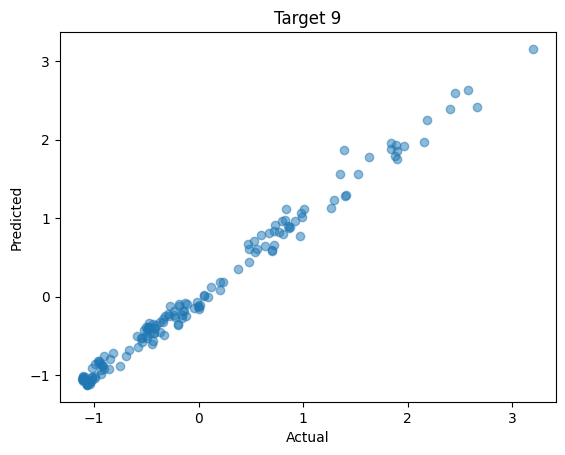

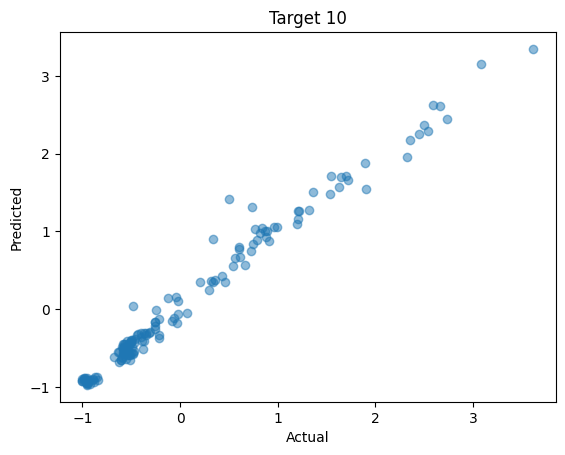

In [398]:
import matplotlib.pyplot as plt

for i in range(y_test.shape[1]):
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Target {i+1}")
    plt.show()


3) Decision Tree

In [399]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=42)

# param grid للـ Decision Tree
param_grid = {
    "estimator__max_depth": [3, 5, 10, None],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4]
}

# MultiOutput مع GridSearchCV
multi_output_dtr = MultiOutputRegressor(dtr)

grid_search = GridSearchCV(
    multi_output_dtr,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=4
)

# تدريب
grid_search.fit(X_train, y_train)

# أفضل باراميترات
print("Best Params:", grid_search.best_params_)

# توقعات
y_pred = grid_search.predict(X_test)

# عكس الـ scaling
y_pred_original = scaler_y.inverse_transform(y_pred)
y_original = scaler_y.inverse_transform(y)
y_test_original = scaler_y.inverse_transform(y_test)



Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5}


In [400]:
# تقييم لكل Target
for i in range(y_test_original.shape[1]):
    mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
    print(f"Target {i+1}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")



Target 1: MSE=21230.63, MAE=87.04, R²=0.9492
Target 2: MSE=70.35, MAE=3.33, R²=0.9649
Target 3: MSE=160054.62, MAE=236.09, R²=0.9786
Target 4: MSE=13405.12, MAE=68.00, R²=0.9761
Target 5: MSE=1155448.44, MAE=691.58, R²=0.9837
Target 6: MSE=3559737.26, MAE=955.51, R²=0.9250
Target 7: MSE=64789.43, MAE=114.55, R²=0.9211
Target 8: MSE=1977.50, MAE=26.27, R²=0.9949
Target 9: MSE=4668.88, MAE=40.20, R²=0.9776
Target 10: MSE=5.36, MAE=0.91, R²=0.9290


In [401]:
# التقييم الكلي
mse = mean_squared_error(y_test_original, y_pred_original, multioutput='uniform_average')
mae = mean_absolute_error(y_test_original, y_pred_original, multioutput='uniform_average')
r2_dt = r2_score(y_test_original, y_pred_original, multioutput='uniform_average')

print(f"Overall MSE: {mse:.2f}")
print(f"Overall MAE: {mae:.2f}")
print(f"Overall R²: {r2_dt:.4f}")

Overall MSE: 498138.76
Overall MAE: 222.35
Overall R²: 0.9600


4) Random Forest

In [402]:
from sklearn.tree import DecisionTreeRegressor


# نعمل الموديل الأساسي
dt = DecisionTreeRegressor(random_state=42)

# param grid للـ Decision Tree
param_grid = {
    "estimator__max_depth": [3, 5, 10, None],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4]
}

# MultiOutput مع GridSearchCV
multi_output_dt = MultiOutputRegressor(dt)

grid_search = GridSearchCV(
    multi_output_dt,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=4
)

# تدريب
grid_search.fit(X_train, y_train)

# أفضل باراميترات
print("Best Params:", grid_search.best_params_)



Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5}


In [403]:
# التنبؤ
y_pred = grid_search.predict(X_test)

# عكس الـ scaling
y_pred_original = scaler_y.inverse_transform(y_pred)
y_original = scaler_y.inverse_transform(y)
y_test_original = scaler_y.inverse_transform(y_test)




In [404]:
# تقييم لكل Target لوحده
for i in range(y_test_original.shape[1]):
    mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
    print(f"Target {i+1}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")



Target 1: MSE=21230.63, MAE=87.04, R²=0.9492
Target 2: MSE=70.35, MAE=3.33, R²=0.9649
Target 3: MSE=160054.62, MAE=236.09, R²=0.9786
Target 4: MSE=13405.12, MAE=68.00, R²=0.9761
Target 5: MSE=1155448.44, MAE=691.58, R²=0.9837
Target 6: MSE=3559737.26, MAE=955.51, R²=0.9250
Target 7: MSE=64789.43, MAE=114.55, R²=0.9211
Target 8: MSE=1977.50, MAE=26.27, R²=0.9949
Target 9: MSE=4668.88, MAE=40.20, R²=0.9776
Target 10: MSE=5.36, MAE=0.91, R²=0.9290


In [405]:
# تقييم كلي
mse = mean_squared_error(y_test_original, y_pred_original, multioutput='uniform_average')
mae = mean_absolute_error(y_test_original, y_pred_original, multioutput='uniform_average')
r2_rf = r2_score(y_test_original, y_pred_original, multioutput='uniform_average')

print(f"Overall MSE: {mse:.2f}")
print(f"Overall MAE: {mae:.2f}")
print(f"Overall R²: {r2_rf:.4f}")

Overall MSE: 498138.76
Overall MAE: 222.35
Overall R²: 0.9600


5) XGBoost

In [406]:
# تأكدي إن X_train و X_test DataFrame بأسامي أعمدة بسيطة
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=[f"f{i}" for i in range(X_train.shape[1])])

if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])

In [407]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

# Define model
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# MultiOutput
multi_output_xgb = MultiOutputRegressor(xgb)

# param grid
param_grid = {
    "estimator__estimator__n_estimators": [100, 200],
    "estimator__estimator__max_depth": [3, 5, 7],
    "estimator__estimator__learning_rate": [0.01, 0.1, 0.2],
    "estimator__estimator__subsample": [0.8, 1.0]
}

# GridSearch
grid_search = GridSearchCV(
    multi_output_xgb,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=4
)

# إعادة تسمية الأعمدة لتفادي الرموز
X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]
X_test.columns  = [f"f{i}" for i in range(X_test.shape[1])]


# Fit
grid_search.fit(X_train, y_train)

# Best Params
print("Best Params:", grid_search.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\NV_USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:41:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "estimator__learning_rate", "estimator__max_depth", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NV_USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:41:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "estimator__learning_rate", "estimator__max_depth", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NV_USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:41:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "estimator__learning_rate", "estimator__max_depth"

Best Params: {'estimator__estimator__learning_rate': 0.01, 'estimator__estimator__max_depth': 3, 'estimator__estimator__n_estimators': 100, 'estimator__estimator__subsample': 0.8}


In [408]:
# التنبؤ
y_pred = grid_search.predict(X_test)

# نرجع القيم الأصلية بعد الـ scaling
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# تقييم لكل target
for i in range(y_test_original.shape[1]):
    mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
    print(f"Target {i+1}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")



Target 1: MSE=10219.89, MAE=66.51, R²=0.9756
Target 2: MSE=39.62, MAE=2.76, R²=0.9802
Target 3: MSE=80801.87, MAE=182.34, R²=0.9892
Target 4: MSE=7832.19, MAE=50.51, R²=0.9861
Target 5: MSE=1246720.86, MAE=616.50, R²=0.9824
Target 6: MSE=2402669.00, MAE=715.01, R²=0.9494
Target 7: MSE=20645.46, MAE=73.12, R²=0.9749
Target 8: MSE=1286.42, MAE=19.64, R²=0.9967
Target 9: MSE=2044.90, MAE=25.49, R²=0.9902
Target 10: MSE=1.50, MAE=0.60, R²=0.9802


In [409]:
# تقييم إجمالي
mse = mean_squared_error(y_test_original, y_pred_original, multioutput='uniform_average')
mae = mean_absolute_error(y_test_original, y_pred_original, multioutput='uniform_average')
r2_xgb = r2_score(y_test_original, y_pred_original, multioutput='uniform_average')

print(f"Overall MSE: {mse:.2f}")
print(f"Overall MAE: {mae:.2f}")
print(f"Overall R²: {r2_xgb:.4f}")

Overall MSE: 377226.17
Overall MAE: 175.25
Overall R²: 0.9805


6) KNN

In [410]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# نعمل KNN
knn = KNeighborsRegressor()

# param grid للـ KNN
param_grid = {
    "estimator__n_neighbors": [3, 5, 7, 9],
    "estimator__weights": ["uniform", "distance"],
    "estimator__p": [1, 2]   # 1 = manhattan, 2 = euclidean
}

# MultiOutput مع GridSearchCV
multi_output_knn = MultiOutputRegressor(knn)

grid_search = GridSearchCV(
    multi_output_knn,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

# تدريب
grid_search.fit(X_train, y_train)

# أفضل باراميترات
print("Best Params:", grid_search.best_params_)



Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params: {'estimator__n_neighbors': 3, 'estimator__p': 1, 'estimator__weights': 'distance'}


In [411]:
# توقع
y_pred = grid_search.predict(X_test)

# نرجع القيم الأصلية (بعد inverse transform)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# تقييم لكل target
for i in range(y_test_original.shape[1]):
    mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
    print(f"Target {i+1}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")




Target 1: MSE=6482.44, MAE=51.90, R²=0.9845
Target 2: MSE=22.02, MAE=2.09, R²=0.9890
Target 3: MSE=38993.99, MAE=129.37, R²=0.9948
Target 4: MSE=3972.55, MAE=38.79, R²=0.9929
Target 5: MSE=549954.64, MAE=415.83, R²=0.9923
Target 6: MSE=1073893.98, MAE=513.29, R²=0.9774
Target 7: MSE=5752.89, MAE=44.71, R²=0.9930
Target 8: MSE=695.94, MAE=16.77, R²=0.9982
Target 9: MSE=3308.37, MAE=22.36, R²=0.9841
Target 10: MSE=0.71, MAE=0.46, R²=0.9906


In [412]:
# تقييم إجمالي
mse = mean_squared_error(y_test_original, y_pred_original, multioutput='uniform_average')
mae = mean_absolute_error(y_test_original, y_pred_original, multioutput='uniform_average')
r2_knn = r2_score(y_test_original, y_pred_original, multioutput='uniform_average')

print(f"Overall MSE: {mse:.2f}")
print(f"Overall MAE: {mae:.2f}")
print(f"Overall R²: {r2_knn:.4f}")

Overall MSE: 168307.75
Overall MAE: 123.56
Overall R²: 0.9897


In [413]:
models = pd.DataFrame({
    'Model':['Linear Regreesion','SVM', 'Decision Tree Classifier', 'Random Forest Classifier','XgBoost', 'KNN Regressor'],
    'Score':[r2_lr*100,r2_svm*100,r2_dt*100,r2_rf*100,r2_xgb*100,r2_knn*100]
})
models.sort_values(by='Score', ascending=False)

Model      Score
5             KNN Regressor  98.967670
1                       SVM  98.099733
4                   XgBoost  98.047320
2  Decision Tree Classifier  96.001348
3  Random Forest Classifier  96.001348
0         Linear Regreesion  94.119710